# Modelo de Machine Learning para Tasa de Autorización (David)


DISTRIBUCIÓN DE ETIQUETAS
Etiqueta 0 (ALTA): 427
Etiqueta 1 (BAJA): 465
Etiqueta 2 (MEDIA): 1,936
Total de registros: 2,828
Tamaño del dataset: X(2828, 40), y(2828,)

DISTRIBUCIÓN EN TRAIN/TEST ORIGINAL
TRAIN ORIGINAL (antes de balanceo):
  Clase 0 (ALTA): 299
  Clase 1 (BAJA): 325
  Clase 2 (MEDIA): 1,355

TEST:
  Clase 0 (ALTA): 128
  Clase 1 (BAJA): 140
  Clase 2 (MEDIA): 581

DISTRIBUCIÓN EN TRAIN/TEST DESPUÉS DE SMOTE-TOMEK
TRAIN (después de SMOTE-Tomek):
  Clase 0 (ALTA): 1,338
  Clase 1 (BAJA): 1,333
  Clase 2 (MEDIA): 1,318

TEST (sin cambios):
  Clase 0 (ALTA): 128
  Clase 1 (BAJA): 140
  Clase 2 (MEDIA): 581
Iniciando búsqueda de hiperparámetros con GridSearchCV...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

Mejores parámetros encontrados:
{'colsample_bytree'

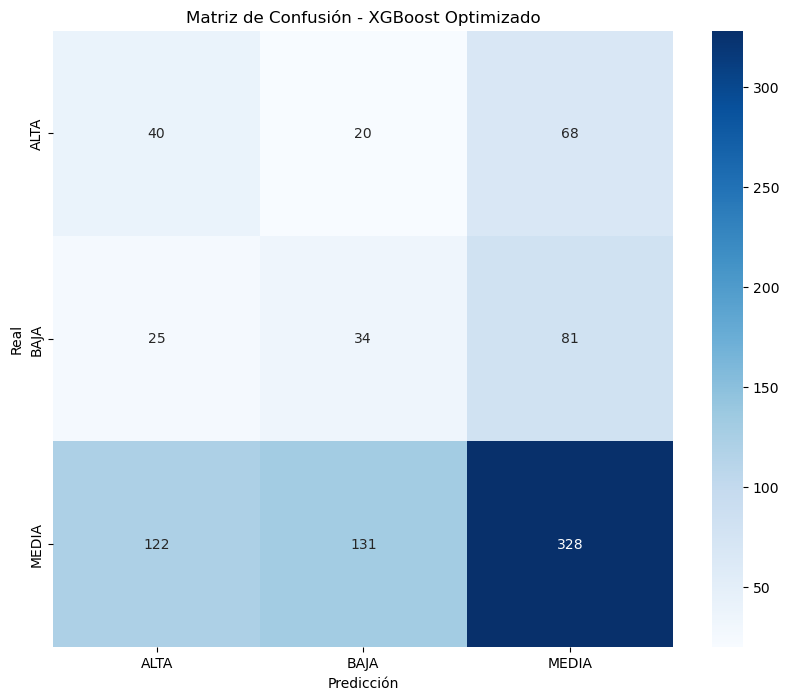

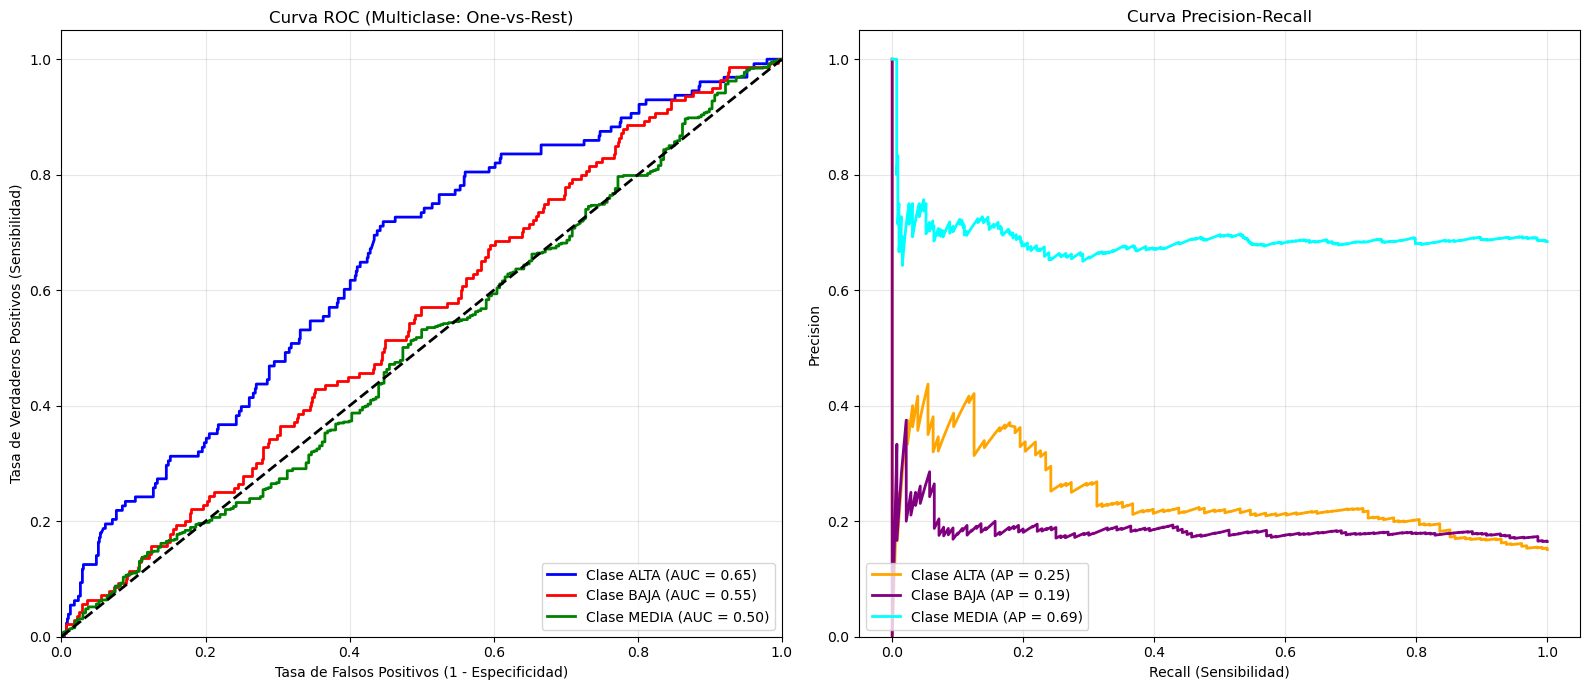


Generando curva de aprendizaje


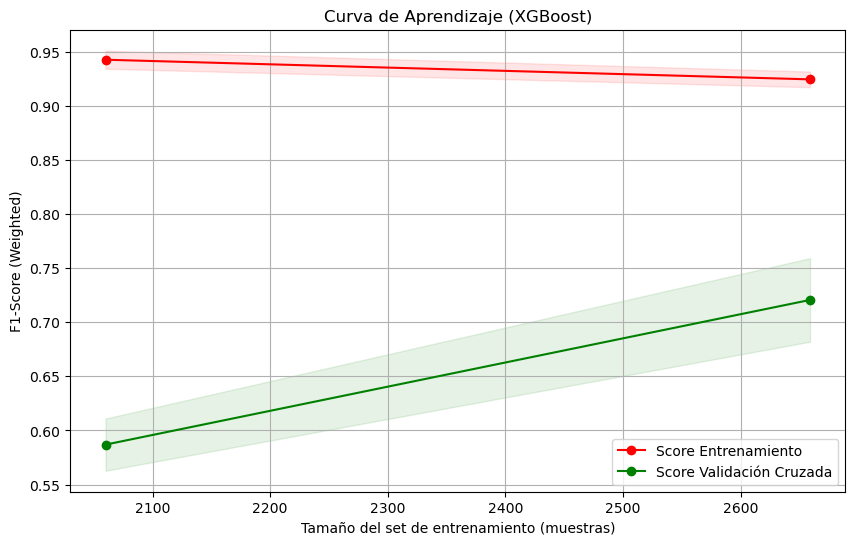

Diferencia final entre Train y Val: 0.2040
DIAGNÓSTICO: El modelo parece equilibrado.
Aún hay un pequeño margen de mejora si consigues más datos.

Validación cruzada con el mejor modelo:
Precisión promedio: 0.738 (+/- 0.027)
F1-score promedio: 0.735 (+/- 0.028)


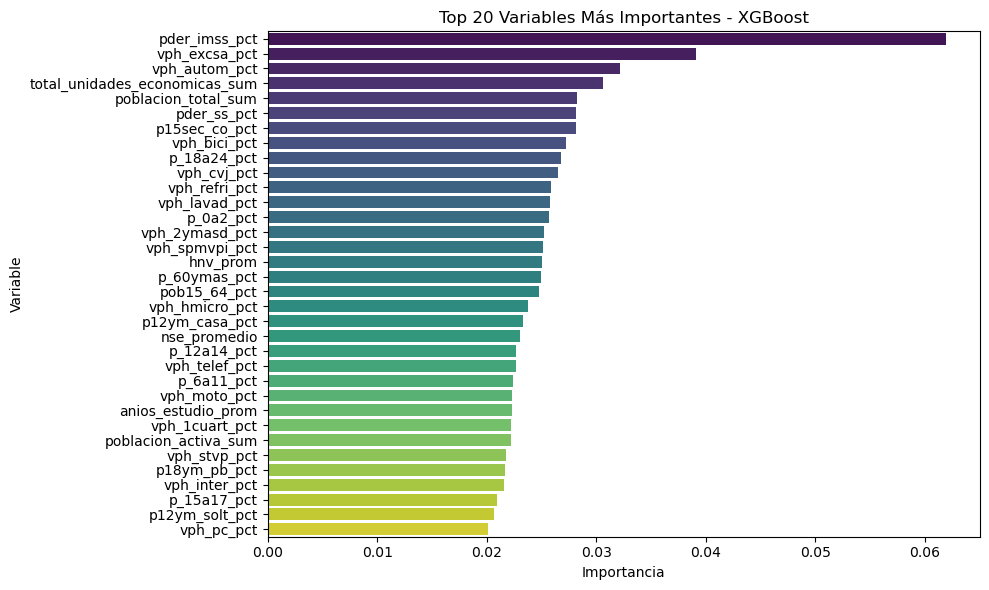


Importancia de variables:
                         Variable  Importancia
26                  pder_imss_pct     0.061932
6                   vph_excsa_pct     0.039116
7                   vph_autom_pct     0.032194
4   total_unidades_economicas_sum     0.030644
3             poblacion_total_sum     0.028216
10                    pder_ss_pct     0.028172
28                  p15sec_co_pct     0.028119
18                   vph_bici_pct     0.027242
34                    p_18a24_pct     0.026770
15                    vph_cvj_pct     0.026479
21                  vph_refri_pct     0.025836
19                  vph_lavad_pct     0.025783
29                      p_0a2_pct     0.025662
16                 vph_2ymasd_pct     0.025246
23                 vph_spmvpi_pct     0.025170
5                        hnv_prom     0.025066
36                   p_60ymas_pct     0.024911
35                   pob15_64_pct     0.024748
20                 vph_hmicro_pct     0.023760
37                 p12ym_casa_pct

In [5]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
import multiprocessing  # <- Nuevo import
import warnings
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')


# Configura para usar todos los núcleos físicos (o menos si quieres dejar recursos libres)
n_cores = multiprocessing.cpu_count()  # Usará 20 en tu caso
os.environ['LOKY_MAX_CPU_COUNT'] = '16'  # Configura todos los núcleos

# os.environ['LOKY_MAX_CPU_COUNT'] = '16'
# Leer el archivo csv
file_name = "./Datasets/Dataset-Entrenamiento.csv"
df = pd.read_csv(file_name, encoding='latin-1', low_memory=False)
 
# Función para limpiar y convertir columnas a numérico
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace('\n', ' ')

# Columnas para agrupar (localidad / manzana)
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']
columnas_grupo = [col for col in columnas_grupo if col in df.columns]
 

# Variables que se deben sumar antes de calcular porcentaje
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir las variables antes de sumar (solo variables presentes)
vars_present = [var for var in variables_a_sumar if var in df.columns]

# Convertir y coercionar a numérico; rellenar NaN con 0 para evitar int + str durante sumas
for var in vars_present:
    df[var] = limpiar_y_convertir(df[var])
df[vars_present] = df[vars_present].apply(pd.to_numeric, errors='coerce').fillna(0)

# Sumar variables por localidad (ahora todas son numéricas)
df_sums = df.groupby(columnas_grupo)[vars_present].sum().reset_index()

# Asegurar que las columnas usadas como denominadores son numéricas y sin valores no válidos
for col in ['tvivparhab', 'pea', 'pobtot','graproes','uni_eco', 'prom_hnv']:
    if col in df.columns:
        # eliminar caracteres problemáticos, convertir y rellenar 0
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('*', '', regex=False), errors='coerce').fillna(0)

# Sumar variables totales para denominadores (incluye promedio de 'graproes')
df_totales = df.groupby(columnas_grupo).agg({
    'graproes': 'mean',
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum',
    'uni_eco': 'sum',
    'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom',
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum',
    'prom_hnv': 'hnv_prom'
})

# Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Calcular porcentajes con base en totales agrupados
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_total_sum']
    else:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['total_viviendas_sum']

# Agregar promedio numérico de NSE por localidad si existe la columna 'nse'
if 'nse' in df.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df['nse'] = pd.Categorical(df['nse'], categories=orden_clases, ordered=True)
    df['nse_num'] = df['nse'].cat.codes
    df_nse_prom = df.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom = df_nse_prom.rename(columns={'nse_num': 'nse_promedio'})
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# Seleccionar variables para modelo: usar solo las variables porcentuales y 'nse_promedio' si existe
variables_pct = [col for col in df_totales.columns if col.endswith('_pct') or col.endswith('_sum') or col.endswith('_prom')]
if 'nse_promedio' in df_totales.columns:
    variables_pct.append('nse_promedio')

# El target 'clasificacion' debe estar en df (agrupar si es necesario)
if 'clasificacion' not in df.columns:
    raise ValueError("La columna 'clasificacion' no está en el dataset original.")
# Agrupar clasificación por localidad (mayoría o modo)
df_clasificacion = df.groupby(columnas_grupo)['clasificacion'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
df_model = pd.merge(df_totales, df_clasificacion, on=columnas_grupo, how='left')
 
# Crear ratios/interacciones importantes
df_model['ratio_viviendas_persona'] = df_model['total_viviendas_sum'] / df_model['poblacion_total_sum']

# Unir con df_totales

 
# Preparar datos para modelo
X = df_model[variables_pct].copy()
y = df_model['clasificacion'].astype('category')

# Reemplazar inf y NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

 
# Dividir en entrenamiento y prueba
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

smote_tomek = SMOTETomek(random_state=42)
X_train, y_train = smote_tomek.fit_resample(X_train_orig, y_train_orig)


print("\n" + "="*40)
print("DISTRIBUCIÓN DE ETIQUETAS")
print("="*40)

# Obtener la distribución antes del split
unique, counts = np.unique(y_encoded, return_counts=True)
class_names = label_encoder.classes_

for i, (cls_num, cls_name) in enumerate(zip(unique, class_names)):
    print(f"Etiqueta {cls_num} ({cls_name}): {counts[i]:,}")

print(f"Total de registros: {len(y_encoded):,}")

# Para problemas binarios, calcular proporción de clase positiva
if len(class_names) == 2:
    if 1 in unique:
        idx_1 = np.where(unique == 1)[0][0]
        proporcion_positiva = counts[idx_1] / len(y_encoded)
        print(f"Proporción positiva: {proporcion_positiva:.4f}")

print(f"Tamaño del dataset: X{X.shape}, y({len(y_encoded)},)")

print("\n" + "="*40)
print("DISTRIBUCIÓN EN TRAIN/TEST ORIGINAL")
print("="*40)

# Distribución en train original (antes de SMOTE)
unique_train_orig, counts_train_orig = np.unique(y_train_orig, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("TRAIN ORIGINAL (antes de balanceo):")
for cls_num, cls_name, count in zip(unique_train_orig, class_names, counts_train_orig):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\nTEST:")
for cls_num, cls_name, count in zip(unique_test, class_names, counts_test):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\n" + "="*40)
print("DISTRIBUCIÓN EN TRAIN/TEST DESPUÉS DE SMOTE-TOMEK")
print("="*40)

# Distribución en train después de SMOTE-Tomek
unique_train_smote, counts_train_smote = np.unique(y_train, return_counts=True)

print("TRAIN (después de SMOTE-Tomek):")
for cls_num, cls_name, count in zip(unique_train_smote, class_names, counts_train_smote):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\nTEST (sin cambios):")
for cls_num, cls_name, count in zip(unique_test, class_names, counts_test):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")


# Configuración inicial de XGBoost con parámetros conservadores para evitar overfitting
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Probar estos hiperparámetros:
best_params_fixed = {
    'colsample_bytree': 0.9,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,
    'n_estimators': 100,
    'subsample': 0.8,
    'reg_alpha': 0,      # Agregados de tu nueva grid
    'reg_lambda': 1      # Agregados de tu nueva grid
}

# Métrica de evaluación (F1 weighted)
# Métrica de evaluación (F1 weighted)
scorer = make_scorer(f1_score, average='weighted')

# Asegurar que GridSearch reciba listas/arrays aunque los valores sean únicos
param_grid_fixed = {k: v if isinstance(v, (list, tuple, np.ndarray)) else [v] for k, v in best_params_fixed.items()}
 
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_fixed,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# ¡CORRECCIÓN! Debes llamar a .fit() para que GridSearch entrene los modelos
# y determine el mejor estimador.
print("Iniciando búsqueda de hiperparámetros con GridSearchCV...")
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Predecir y evaluar
y_pred = best_xgb.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calcular probabilidades para métricas ROC/AUC
y_pred_proba = best_xgb.predict_proba(X_test)

# Obtener probabilidades para la clase positiva (asumiendo clase 1 como positiva)
# En problemas multiclase necesitamos adaptar para cada clase
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Si es problema binario
if len(label_encoder.classes_) == 2:
    y_pred_proba_pos = y_pred_proba[:, 1]
    y_test_bin = y_test
    
    # Calcular métricas
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba_pos)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
else:
    # Para multiclase: usar One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    
    # Calcular ROC AUC para multiclase
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("MÉTRICAS DETALLADAS DEL MODELO")
print("="*60)
print(f"roc_auc: {roc_auc:.4f}")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")
print("="*60)

# Calcular matriz de confusión detallada
conf_matrix = confusion_matrix(y_test, y_pred)

# Extraer valores de la matriz de confusión
if len(label_encoder.classes_) == 2:
    TN, FP, FN, TP = conf_matrix.ravel()
    print(f"\nMATRIZ DE CONFUSIÓN DETALLADA:")
    print(f"Verdaderos Negativos (TN): {TN}")
    print(f"Falsos Positivos (FP):     {FP}")
    print(f"Falsos Negativos (FN):     {FN}")
    print(f"Verdaderos Positivos (TP): {TP}")
else:
    print(f"\nMatriz de confusión (multiclase - forma {conf_matrix.shape}):")
    print(conf_matrix)

# Calcular threshold óptimo para problemas binarios
if len(label_encoder.classes_) == 2:
    from sklearn.metrics import roc_curve
    import numpy as np
    
    # Threshold basado en ROC (Youden's J statistic)
    fpr, tpr, thresholds_roc = roc_curve(y_test_bin, y_pred_proba_pos)
    j_scores = tpr - fpr
    optimal_idx_roc = np.argmax(j_scores)
    optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
    
    # Threshold basado en F1-score
    f1_scores = []
    thresholds_f1 = np.arange(0.1, 0.9, 0.01)
    
    for threshold in thresholds_f1:
        y_pred_thresh = (y_pred_proba_pos >= threshold).astype(int)
        f1_val = f1_score(y_test_bin, y_pred_thresh)
        f1_scores.append(f1_val)
    
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = thresholds_f1[optimal_idx_f1]
    
    print(f"\nTHRESHOLDS ÓPTIMOS:")
    print(f"Threshold óptimo (ROC-based): {optimal_threshold_roc:.4f}")
    print(f"Threshold óptimo (F1-based): {optimal_threshold_f1:.4f}")

print("="*60)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - XGBoost Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ==============================================================================
# GRÁFICOS DE CURVAS ROC Y PRECISION-RECALL
# ==============================================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Preparar datos (Binarizar etiquetas para Multiclase)
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Si es binario, label_binarize devuelve una columna, necesitamos forma (n_samples, 1) o (n_samples, 2)
# Ajuste para consistencia si es binario estricto
if n_classes == 2:
    # Para 2 clases, y_test_bin es vector columna. 
    # ROC curve necesita y_true y y_score de la clase positiva.
    # Vamos a tratarlo genéricamente iterando sobre las clases.
    # Re-binarizamos explícitamente a 2 columnas para el bucle
    y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

# 2. Configurar la figura (2 subplots: Izquierda ROC, Derecha PR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Colores para las clases
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])

# --- GRAFICO 1: CURVA ROC ---
for i, color in zip(range(n_classes), colors):
    # Calcular FPR y TPR
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plotear
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'Clase {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2) # Línea diagonal de azar
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax1.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
ax1.set_title('Curva ROC (Multiclase: One-vs-Rest)')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# --- GRAFICO 2: CURVA PRECISION-RECALL ---
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'Clase {label_encoder.classes_[i]} (AP = {average_precision:.2f})')

ax2.set_xlabel('Recall (Sensibilidad)')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend(loc="lower left")
ax2.grid(alpha=0.3)
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# ==============================================================================
# GRÁFICO DE CURVA DE APRENDIZAJE (LEARNING CURVE)
# ==============================================================================
from sklearn.model_selection import learning_curve

print("\nGenerando curva de aprendizaje")

# Configuración de la curva
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_xgb,
    X=X_train,           # Usamos los datos de entrenamiento (balanceados)
    y=y_train,
    cv=3,                # 3 folds para que sea más rápido
    n_jobs=-1,           # Usar todos los núcleos
    train_sizes=np.linspace(0.1, 1.0, 5), # Evaluar en 5 puntos del tamaño del dataset
    scoring='f1_weighted' # Métrica consistente con tu GridSearch
)

# Calcular promedios y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score Validación Cruzada")

# Dibujar bandas de varianza (desviación estándar)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.title("Curva de Aprendizaje (XGBoost)")
plt.xlabel("Tamaño del set de entrenamiento (muestras)")
plt.ylabel("F1-Score (Weighted)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================================================================
# INTERPRETACIÓN AUTOMÁTICA
# ==============================================================================
gap = train_mean[-1] - test_mean[-1]
print(f"Diferencia final entre Train y Val: {gap:.4f}")

if train_mean[-1] > 0.95 and test_mean[-1] < 0.85:
    print("DIAGNÓSTICO: Posible Overfitting (Alta varianza).")
    print("Sugerencia: Aumentar regularización (reg_alpha/lambda), reducir max_depth o conseguir más datos.")
elif train_mean[-1] < 0.70 and test_mean[-1] < 0.70:
    print("DIAGNÓSTICO: Posible Underfitting (Alto sesgo).")
    print("Sugerencia: Hacer el modelo más complejo (más depth, menos regularización) o mejorar las features.")
else:
    print("DIAGNÓSTICO: El modelo parece equilibrado.")
    if test_mean[-1] < train_mean[-1]:
        print("Aún hay un pequeño margen de mejora si consigues más datos.")

# Validación cruzada con el mejor modelo
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_accuracy = cross_val_score(best_xgb, X_train, y_train, cv=skf, scoring='accuracy')
scores_f1 = cross_val_score(best_xgb, X_train, y_train, cv=skf, scoring='f1_weighted')

print("\nValidación cruzada con el mejor modelo:")
print(f"Precisión promedio: {scores_accuracy.mean():.3f} (+/- {scores_accuracy.std() * 2:.3f})")
print(f"F1-score promedio: {scores_f1.mean():.3f} (+/- {scores_f1.std() * 2:.3f})")

# Importancia de variables
importancias = best_xgb.feature_importances_
importancias_df = pd.DataFrame({'Variable': variables_pct, 'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancias_df.head(34), palette="viridis")
plt.title("Top 20 Variables Más Importantes - XGBoost")
plt.tight_layout()
plt.show()

print("\nImportancia de variables:")
print(importancias_df.head(34))

# Guardar modelo
modelo_path = "Modelos A\\modelo_xgboost_optimizado.pkl"
joblib.dump(best_xgb, modelo_path)
print(f"\nModelo guardado en: {modelo_path}")

# Guardar el label encoder también
encoder_path = "Modelos A\\label_encoder.pkl"
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder guardado en: {encoder_path}")



## Modelo de David aplicado a todos los municipios

In [7]:
import pandas as pd
import numpy as np
import joblib
import multiprocessing
import os
import warnings

warnings.filterwarnings('ignore')

# 1. Configurar núcleos
n_cores = multiprocessing.cpu_count()
os.environ['LOKY_MAX_CPU_COUNT'] = str(n_cores)

# 2. Cargar modelo y label encoder
modelo_path = 'Modelos A\\modelo_xgboost_optimizado.pkl'
label_encoder_path = 'Modelos A\\label_encoder.pkl'

if not os.path.exists(modelo_path) or not os.path.exists(label_encoder_path):
    raise FileNotFoundError("Asegúrate de tener 'modelo_xgboost_optimizado.pkl' y 'label_encoder.pkl' en el directorio.")

model = joblib.load(modelo_path)
label_encoder = joblib.load(label_encoder_path)
print("Modelo y LabelEncoder cargados exitosamente")

# 3. Cargar y preparar nuevos datos
df_nuevo = pd.read_csv("./Datasets/07.NSE.csv")
df_nuevo.columns = df_nuevo.columns.str.strip().str.lower().str.replace('\n', ' ')

# 4. Función de limpieza (Misma lógica del entrenamiento)
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# 5. Columnas para agrupar
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']
columnas_grupo = [col for col in columnas_grupo if col in df_nuevo.columns]

# 6. Variables a procesar (Basado en el nuevo modelo)
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir variables de suma
for var in variables_a_sumar:
    if var in df_nuevo.columns:
        df_nuevo[var] = limpiar_y_convertir(df_nuevo[var])

# 7. Realizar agrupaciones (Sumas, Promedios y Totales)
# Primero las sumas de variables específicas
df_sums = df_nuevo.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()

# Limpiar variables para denominadores y promedios
cols_especiales = ['graproes', 'tvivparhab', 'pea', 'pobtot', 'uni_eco', 'prom_hnv']
for col in cols_especiales:
    if col in df_nuevo.columns:
        df_nuevo[col] = limpiar_y_convertir(df_nuevo[col])

# Agregaciones de totales y promedios
df_totales = df_nuevo.groupby(columnas_grupo).agg({
    'graproes': 'mean',
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum',
    'uni_eco': 'sum',
    'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom',
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum',
    'prom_hnv': 'hnv_prom'
})

# Unir sumas y totales
df_proc = pd.merge(df_sums, df_totales, on=columnas_grupo)

# 8. Calcular porcentajes (_pct)
for var in variables_a_sumar:
    if var not in df_proc.columns:
        continue
    
    # Denominador según el tipo de variable (Lógica exacta del modelo de entrenamiento)
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        denominador = df_proc['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        denominador = df_proc['poblacion_total_sum']
    else:
        denominador = df_proc['total_viviendas_sum']
    
    df_proc[var + '_pct'] = df_proc[var] * 100 / denominador.replace(0, np.nan)

# 9. Agregar NSE promedio (si está disponible)
if 'nse' in df_nuevo.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df_nuevo['nse'] = pd.Categorical(df_nuevo['nse'], categories=orden_clases, ordered=True)
    df_nuevo['nse_num'] = df_nuevo['nse'].cat.codes
    df_nse_prom = df_nuevo.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom.rename(columns={'nse_num': 'nse_promedio'}, inplace=True)
    df_proc = pd.merge(df_proc, df_nse_prom, on=columnas_grupo, how='left')

# 10. Crear Ratios e Interacciones (Nuevas variables del modelo)
df_proc['ratio_viviendas_persona'] = df_proc['total_viviendas_sum'] / df_proc['poblacion_total_sum'].replace(0, np.nan)

# Dependencia Económica
df_proc['dependencia_economica'] = (df_proc['p_0a2_pct'] + df_proc['p_3a5_pct'] + 
                                   df_proc['p_60ymas_pct']) / df_proc['pob15_64_pct'].replace(0, np.nan)

# 11. Alinear con las columnas que el modelo espera
features_modelo = model.feature_names_in_
X_pred = df_proc.reindex(columns=features_modelo)

# 12. Limpieza final de valores infinitos o nulos
X_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# Rellenar con 0 para ser consistente con el relleno de entrenamiento: X.fillna(0, inplace=True)
X_pred.fillna(0, inplace=True)

# 13. Predecir
probabilidades = model.predict_proba(X_pred)
clases_nombres = label_encoder.classes_

# 14. Crear DataFrame de resultados
resultados = df_proc[columnas_grupo].copy()
for i, clase in enumerate(clases_nombres):
    resultados[f'prob_{clase}'] = probabilidades[:, i]

# Clasificación final
resultados['clasificacion_predicha'] = label_encoder.inverse_transform(np.argmax(probabilidades, axis=1))
resultados['prob_maxima'] = np.max(probabilidades, axis=1)

# 15. Exportar
output_path = r"./Predicciones/tasa-de-autorizacion-por-municipio.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
resultados.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\nProceso completado.")
print(f"Resultados guardados en: {output_path}")
print(f"Total de registros procesados: {len(resultados)}")
print(f"Muestra de resultados:\n", resultados[columnas_grupo + ['clasificacion_predicha', 'prob_maxima']].head())


# ==============================================================================
# ANÁLISIS DE DISTRIBUCIÓN POR ENTIDAD Y MUNICIPIO
# ==============================================================================

print("\n" + "="*60)
print("RESUMEN DE COMPORTAMIENTO DEL MODELO")
print("="*60)

# 1. Distribución de Etiquetas por Entidad (¿Qué está prediciendo en cada estado?)
print("\n1. Distribución de clasificaciones por Entidad (Top 10):")
dist_entidad = resultados.groupby(['nom_ent', 'clasificacion_predicha']).size().unstack(fill_value=0)
# Calcular porcentajes para mejor interpretación
dist_entidad_pct = dist_entidad.div(dist_entidad.sum(axis=1), axis=0) * 100
print(dist_entidad_pct.head(10).round(2).astype(str) + '%')

# 2. Promedio de Probabilidades por Entidad (¿Qué tan seguro está el modelo en cada estado?)
print("\n2. Seguridad del modelo (Probabilidad promedio) por Entidad:")
prob_cols = [f'prob_{clase}' for clase in label_encoder.classes_]
avg_probs_ent = resultados.groupby('nom_ent')[prob_cols].mean()
print(avg_probs_ent.head(10).round(4))

# 3. Análisis a nivel Municipio (Agrupado por Entidad)
# Vamos a ver los 5 municipios con mayor probabilidad máxima (más seguros) 
# y los 5 con menor (donde el modelo duda más)
print("\n3. Top 5 Municipios con mayor certeza (Prob Máxima):")
municipios_seguros = resultados.groupby(['nom_ent', 'nom_mun'])['prob_maxima'].mean().sort_values(ascending=False).head(5)
print(municipios_seguros)

print("\n4. Top 5 Municipios con menor certeza (Donde el modelo tiene dudas):")
municipios_duda = resultados.groupby(['nom_ent', 'nom_mun'])['prob_maxima'].mean().sort_values(ascending=True).head(5)
print(municipios_duda)

# 5. Resumen General de Predicciones a nivel Nacional
print("\n5. Conteo Total Nacional de Predicciones:")
conteo_nacional = resultados['clasificacion_predicha'].value_counts()
conteo_nacional_pct = resultados['clasificacion_predicha'].value_counts(normalize=True) * 100
resumen_nac = pd.DataFrame({
    'Cantidad': conteo_nacional,
    'Porcentaje': conteo_nacional_pct.round(2).astype(str) + '%'
})
print(resumen_nac)

 
 

Modelo y LabelEncoder cargados exitosamente

Proceso completado.
Resultados guardados en: ./Predicciones/tasa-de-autorizacion-por-municipio.csv
Total de registros procesados: 28124
Muestra de resultados:
           nom_ent         nom_mun         nom_loc cveid_enti  \
0  Aguascalientes  Aguascalientes  Aguascalientes     1000-1   
1  Aguascalientes  Aguascalientes  Aguascalientes     1002-1   
2  Aguascalientes  Aguascalientes  Aguascalientes     1003-1   
3  Aguascalientes  Aguascalientes  Aguascalientes     1004-1   
4  Aguascalientes  Aguascalientes  Aguascalientes     1005-1   

                     nombre clasificacion_predicha  prob_maxima  
0     MISION DE SANTIAGO  I                  MEDIA     0.841860  
1                  LA SALUD                  MEDIA     0.557789  
2  RINCONADA DE LA ASUNCION                  MEDIA     0.669997  
3                 AUSTRALIS                  MEDIA     0.831745  
4              SOL NACIENTE                   BAJA     0.577781  

RESUMEN DE CO

### Modelo Aplicado a Municipio

In [5]:
import pandas as pd
import numpy as np
import joblib
import multiprocessing
import os

# Configurar núcleos
n_cores = multiprocessing.cpu_count()
os.environ['LOKY_MAX_CPU_COUNT'] = '16'

# 1. Cargar modelo y label encoder
modelo_path = 'modelo_xgboost_optimizado.pkl'
rf_model = joblib.load(modelo_path)
label_encoder = joblib.load('label_encoder.pkl')
print("Modelo y LabelEncoder cargados exitosamente")

# 2. Cargar y preparar nuevos datos
df_nuevo = pd.read_csv("./Datasets/07.NSE.csv")

munis = [
        "Aguascalientes","Jerécuaro","Moroleón","Uriangato","Sahuayo",
        "Compostela","Xalisco","Tepic","Querétaro","Zacatecas","Acambay de Ruíz CastaÃ±eda",
        "Jacona","Ixtlán del Río"
]
munis_upper = [m.upper() for m in munis]
munis_existentes = df_nuevo['nom_mun'].str.upper().unique()
faltantes = [m for m in munis_upper if m not in munis_existentes]
if faltantes:
    raise ValueError(f"Los siguientes municipios no existen en el DataFrame: {faltantes}")

df_ags = df_nuevo[df_nuevo['nom_mun'].str.upper().isin(munis_upper)].copy()

# 3. Función de limpieza
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# 4. Columnas para agrupar
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'NOMBRE', 'CVEID_ENTI']
columnas_grupo = [col for col in columnas_grupo if col in df_ags.columns]

# 5. Variables a sumar
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]
for var in variables_a_sumar:
    if var in df_ags.columns:
        df_ags[var] = limpiar_y_convertir(df_ags[var])

# 6. Sumar por localidad
df_sums = df_ags.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()
# Primero limpiamos las columnas numéricas
for col in ['tvivparhab', 'pea', 'pobtot']:
    if col in df_ags.columns:
        df_ags[col] = limpiar_y_convertir(df_ags[col])
# 7. Totales
df_totales = df_ags.groupby(columnas_grupo).agg({
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum'
}).reset_index().rename(columns={
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum'
})

# 8. Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Limpiar columnas totales
df_totales['total_viviendas_sum'] = pd.to_numeric(df_totales['total_viviendas_sum'].astype(str).str.replace('*','',regex=False), errors='coerce')
df_totales['poblacion_activa_sum'] = pd.to_numeric(df_totales['poblacion_activa_sum'].astype(str).str.replace('*','',regex=False), errors='coerce')
df_totales['poblacion_total_sum'] = pd.to_numeric(df_totales['poblacion_total_sum'], errors='coerce')

# 9. Calcular porcentajes
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['poblacion_activa_sum'].replace(0, np.nan)
    elif var in ['pder_ss','p_0a2','p_3a5','p_6a11','p_12a14','p_15a17','p_18a24',
                 'pob15_64','p_60ymas','p12ym_casa','p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['poblacion_total_sum'].replace(0, np.nan)
    else:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['total_viviendas_sum'].replace(0, np.nan)

# 10. NSE promedio
if 'nse' in df_ags.columns and 'nse_promedio' in rf_model.feature_names_in_:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df_ags['nse'] = pd.Categorical(df_ags['nse'], categories=orden_clases, ordered=True)
    df_ags['nse_num'] = df_ags['nse'].cat.codes
    df_nse_prom = df_ags.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom.rename(columns={'nse_num':'nse_promedio'}, inplace=True)
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# 11. Variables para modelo
variables_pct = [col for col in df_totales.columns if col.endswith('_pct')]
if 'nse_promedio' in df_totales.columns and 'nse_promedio' in rf_model.feature_names_in_:
    variables_pct.append('nse_promedio')

# 12. Completar variables faltantes
missing_vars = set(rf_model.feature_names_in_) - set(variables_pct)
for var in missing_vars:
    if var not in df_totales.columns:
        df_totales[var] = np.nan

# Orden correcto
X_ags = df_totales[rf_model.feature_names_in_].copy()

# 13. Limpieza final
X_ags.replace([np.inf, -np.inf], np.nan, inplace=True)
X_ags.fillna(X_ags.median(), inplace=True)

# 14. Predecir probabilidades
probabilidades = rf_model.predict_proba(X_ags)
clases_numericas = rf_model.classes_
clases = label_encoder.inverse_transform(clases_numericas)

# 15. Crear DataFrame resultados
resultados = df_totales[columnas_grupo].copy()
for i, clase in enumerate(clases):
    resultados[f'prob_{clase}'] = probabilidades[:, i]

# Clasificación más probable
resultados['clasificacion_predicha'] = label_encoder.inverse_transform(np.argmax(probabilidades, axis=1))
resultados['prob_maxima'] = np.max(probabilidades, axis=1)

# 16. Columnas de salida
columnas_output = columnas_grupo + [f'prob_{clase}' for clase in clases] + ['clasificacion_predicha','prob_maxima']
df_final = resultados[columnas_output]

# Mostrar y guardar
print("\nMuestra de resultados:")
print(df_final.head())

output_path = r"./Predicciones/tasa-de-autorizacion-por-municipio.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_final.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\nResultados guardados en: {output_path}")


Modelo y LabelEncoder cargados exitosamente


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_26556\1125218262.py:18: DtypeWarning: Columns (6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,233,237,243,244,245,247,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nuevo


Muestra de resultados:
          nom_ent         nom_mun         nom_loc       NOMBRE CVEID_ENTI  \
0  Aguascalientes  Aguascalientes  Aguascalientes       14 ava      255-1   
1  Aguascalientes  Aguascalientes  Aguascalientes  AGRICULTURA      284-1   
2  Aguascalientes  Aguascalientes  Aguascalientes   AGUA CLARA      316-1   
3  Aguascalientes  Aguascalientes  Aguascalientes      ALAMEDA      684-1   
4  Aguascalientes  Aguascalientes  Aguascalientes      ALBERIA     1039-1   

   prob_ALTA  prob_BAJA  prob_MEDIA clasificacion_predicha  prob_maxima  
0   0.046019   0.013616    0.940365                  MEDIA     0.940365  
1   0.207356   0.182712    0.609932                  MEDIA     0.609932  
2   0.016085   0.074295    0.909620                  MEDIA     0.909620  
3   0.020124   0.619483    0.360393                   BAJA     0.619483  
4   0.228291   0.037300    0.734409                  MEDIA     0.734409  

Resultados guardados en: ./Predicciones/tasa-de-autorizacion-por-mun

## Modelo Aplicado a todos los Municipios

In [15]:
import pandas as pd
import numpy as np
import joblib
import multiprocessing
import os

# Configurar núcleos
n_cores = multiprocessing.cpu_count()
os.environ['LOKY_MAX_CPU_COUNT'] = '16'

# 1. Cargar modelo y label encoder
modelo_path = 'modelo_xgboost_optimizado.pkl'
rf_model = joblib.load(modelo_path)
label_encoder = joblib.load('label_encoder.pkl')
print("Modelo y LabelEncoder cargados exitosamente")

# 2. Cargar y preparar nuevos datos
df_nuevo = pd.read_csv("./Datasets/07.NSE.csv")

# Obtener todos los municipios únicos en lugar de una lista específica
munis_upper = df_nuevo['nom_mun'].str.upper().unique()

# 3. Función de limpieza
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# 4. Columnas para agrupar
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'CVEID_ENTI', 'NOMBRE']
columnas_grupo = [col for col in columnas_grupo if col in df_nuevo.columns]

# 5. Variables a sumar
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Aplicar limpieza a todas las variables
for var in variables_a_sumar:
    if var in df_nuevo.columns:
        df_nuevo[var] = limpiar_y_convertir(df_nuevo[var])

# 6. Sumar por localidad
df_sums = df_nuevo.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()

# Limpiar columnas numéricas para totales
for col in ['tvivparhab', 'pea', 'pobtot']:
    if col in df_nuevo.columns:
        df_nuevo[col] = limpiar_y_convertir(df_nuevo[col])

# 7. Totales
df_totales = df_nuevo.groupby(columnas_grupo).agg({
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum'
}).reset_index().rename(columns={
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum'
})

# 8. Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Limpiar columnas totales
df_totales['total_viviendas_sum'] = pd.to_numeric(df_totales['total_viviendas_sum'].astype(str).str.replace('*','',regex=False), errors='coerce')
df_totales['poblacion_activa_sum'] = pd.to_numeric(df_totales['poblacion_activa_sum'].astype(str).str.replace('*','',regex=False), errors='coerce')
df_totales['poblacion_total_sum'] = pd.to_numeric(df_totales['poblacion_total_sum'], errors='coerce')

# 9. Calcular porcentajes
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['poblacion_activa_sum'].replace(0, np.nan)
    elif var in ['pder_ss','p_0a2','p_3a5','p_6a11','p_12a14','p_15a17','p_18a24',
                 'pob15_64','p_60ymas','p12ym_casa','p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['poblacion_total_sum'].replace(0, np.nan)
    else:
        df_totales[var + '_pct'] = df_totales[var]*100/df_totales['total_viviendas_sum'].replace(0, np.nan)

# 10. NSE promedio
if 'nse' in df_nuevo.columns and 'nse_promedio' in rf_model.feature_names_in_:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df_nuevo['nse'] = pd.Categorical(df_nuevo['nse'], categories=orden_clases, ordered=True)
    df_nuevo['nse_num'] = df_nuevo['nse'].cat.codes
    df_nse_prom = df_nuevo.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom.rename(columns={'nse_num':'nse_promedio'}, inplace=True)
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# 11. Variables para modelo
variables_pct = [col for col in df_totales.columns if col.endswith('_pct')]
if 'nse_promedio' in df_totales.columns and 'nse_promedio' in rf_model.feature_names_in_:
    variables_pct.append('nse_promedio')

# 12. Completar variables faltantes
missing_vars = set(rf_model.feature_names_in_) - set(variables_pct)
for var in missing_vars:
    if var not in df_totales.columns:
        df_totales[var] = np.nan

# Orden correcto
X_ags = df_totales[rf_model.feature_names_in_].copy()

# 13. Limpieza final
X_ags.replace([np.inf, -np.inf], np.nan, inplace=True)
X_ags.fillna(X_ags.median(), inplace=True)

# 14. Predecir probabilidades
probabilidades = rf_model.predict_proba(X_ags)
clases_numericas = rf_model.classes_
clases = label_encoder.inverse_transform(clases_numericas)

# 15. Crear DataFrame resultados
resultados = df_totales[columnas_grupo].copy()
for i, clase in enumerate(clases):
    resultados[f'prob_{clase}'] = probabilidades[:, i]

# Clasificación más probable
resultados['clasificacion_predicha'] = label_encoder.inverse_transform(np.argmax(probabilidades, axis=1))
resultados['prob_maxima'] = np.max(probabilidades, axis=1)

# 16. Columnas de salida
columnas_output = columnas_grupo + [f'prob_{clase}' for clase in clases] + ['clasificacion_predicha','prob_maxima']
df_final = resultados[columnas_output]

# Mostrar y guardar
print("\nMuestra de resultados:")
print(df_final.head())

output_path = r"./Predicciones/tasa-de-autorizacion-por-municipio.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_final.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\nResultados guardados en: {output_path}")
print(f"Total de municipios procesados: {len(df_final['nom_mun'].unique())}")

Modelo y LabelEncoder cargados exitosamente


C:\Users\jose.valdez\AppData\Local\Temp\ipykernel_21892\1553885394.py:18: DtypeWarning: Columns (6,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,233,237,243,244,245,247,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nuevo


Muestra de resultados:
          nom_ent         nom_mun         nom_loc CVEID_ENTI  \
0  Aguascalientes  Aguascalientes  Aguascalientes     1000-1   
1  Aguascalientes  Aguascalientes  Aguascalientes     1002-1   
2  Aguascalientes  Aguascalientes  Aguascalientes     1003-1   
3  Aguascalientes  Aguascalientes  Aguascalientes     1004-1   
4  Aguascalientes  Aguascalientes  Aguascalientes     1005-1   

                     NOMBRE  prob_ALTA  prob_BAJA  prob_MEDIA  \
0     MISION DE SANTIAGO  I   0.032487   0.208279    0.759233   
1                  LA SALUD   0.067452   0.105405    0.827143   
2  RINCONADA DE LA ASUNCION   0.118778   0.118373    0.762850   
3                 AUSTRALIS   0.329414   0.034317    0.636269   
4              SOL NACIENTE   0.003194   0.632406    0.364399   

  clasificacion_predicha  prob_maxima  
0                  MEDIA     0.759233  
1                  MEDIA     0.827143  
2                  MEDIA     0.762850  
3                  MEDIA     0.636269  


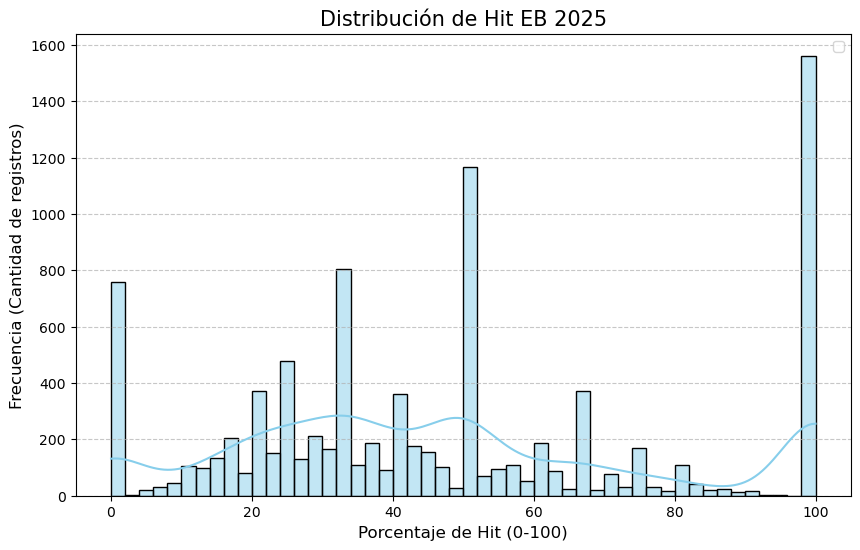

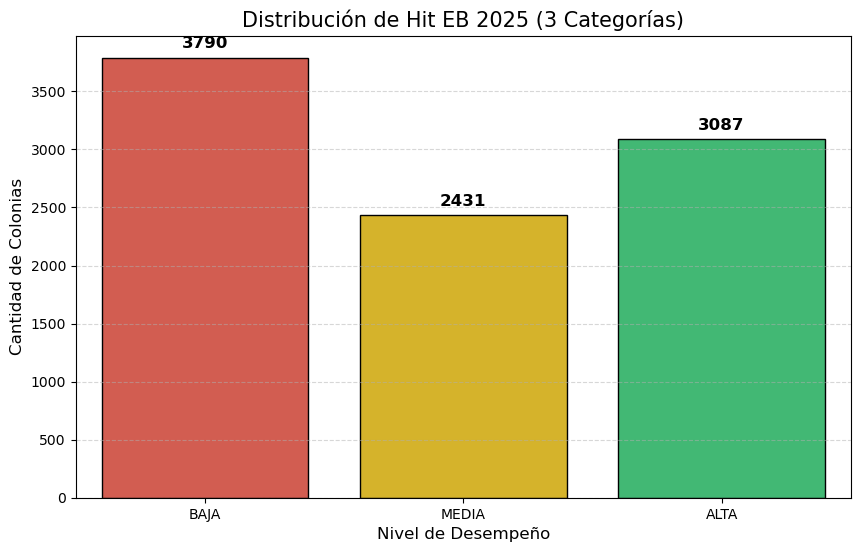

Conteo por categoría:
clasificacion
BAJA     3790
MEDIA    2431
ALTA     3087
Name: count, dtype: int64
0
(173108, 255)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

 

df = pd.read_csv("./hit de aut por colonia/datos_combinados.csv", encoding='latin-1', low_memory=False)
df['hit EB 2025'] = df['hit EB 2025'].fillna(df['hit EB 2024']).fillna(df['hit EB 2023']).fillna(0)

# 1. Limpieza de datos
# Quitamos el '%' y convertimos a número
df['hit EB 2025'] = df['hit EB 2025'].astype(str).str.replace('%', '', regex=False)
df['hit EB 2025'] = pd.to_numeric(df['hit EB 2025'], errors='coerce')

# ---------------------------------------------------------
# AQUÍ ESTÁ EL CAMBIO SOLICITADO:
# Cualquier valor mayor a 100 se convierte en 100.
# ---------------------------------------------------------
df.loc[df['hit EB 2025'] > 100, 'hit EB 2025'] = 100

# Opción alternativa más corta ("clip" corta los picos):
# df['hit EB 2025'] = df['hit EB 2025'].clip(upper=100)

# 2. Crear el Histograma
plt.figure(figsize=(10, 6))

# Ajusté los bins a 50. Como ahora el rango es fijo de 0 a 100, 
# 1000 bins serían demasiados (barras muy finas). 50 o 100 es ideal.
sns.histplot(df['hit EB 2025'], bins=50, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribución de Hit EB 2025', fontsize=15)
plt.xlabel('Porcentaje de Hit (0-100)', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de registros)', fontsize=12)

# Añadir una línea roja para marcar el tope
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 1. Limpieza y Tope al 100%
df['hit EB 2025'] = df['hit EB 2025'].astype(str).str.replace('%', '', regex=False)
df['hit EB 2025'] = pd.to_numeric(df['hit EB 2025'], errors='coerce')
df.loc[df['hit EB 2025'] > 100, 'hit EB 2025'] = 100

# ---------------------------------------------------------
# 2. DEFINICIÓN DE LAS 3 CATEGORÍAS (PERSONALIZABLE)
# ---------------------------------------------------------
# Necesitas 4 números para crear 3 grupos.
# Ejemplo: 
#   0 a 50  -> BAJA
#   50 a 80 -> MEDIA
#   80 a 100 -> ALTA
#mis_bins = [0, 30, 60, 100] 
mis_etiquetas = ['BAJA', 'MEDIA', 'ALTA']

# Colores para el gráfico (Rojo, Amarillo, Verde)
mis_colores = {'BAJA': '#e74c3c', 'MEDIA': '#f1c40f', 'ALTA': '#2ecc71'}

# Crear la columna de categorías
# df['clasificacion'] = pd.cut(df['hit EB 2025'], 
#                              bins=mis_bins, 
#                              labels=mis_etiquetas, 
#                              include_lowest=True) # Importante para incluir el 0
df['clasificacion'] = pd.qcut(df['hit EB 2025'], q=3, labels=['BAJA', 'MEDIA', 'ALTA'])

# ---------------------------------------------------------
# 3. GRÁFICA DE LA DISTRIBUCIÓN
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Usamos countplot para contar categorías
ax = sns.countplot(x='clasificacion', data=df, palette=mis_colores, edgecolor='black')

plt.title('Distribución de Hit EB 2025 (3 Categorías)', fontsize=15)
plt.xlabel('Nivel de Desempeño', fontsize=12)
plt.ylabel('Cantidad de Colonias', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Poner los números exactos encima de las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.show()

# Mostrar resumen en texto
print("Conteo por categoría:")
print(df['clasificacion'].value_counts().sort_index())


df_nse = pd.read_csv("./Datasets/07.NSE.csv")
df_nse.shape

df_nse = df_nse.merge(
    df[['CVEID_ENTI', 'clasificacion', 'hit EB 2025']],
    on='CVEID_ENTI',
    how='inner'
)

print(df_nse['clasificacion'].isnull().sum())
print(df_nse.shape)


## Modelo Tasa de Autorización


DISTRIBUCIÓN DE ETIQUETAS
Etiqueta 0 (ALTA): 2,191
Etiqueta 1 (BAJA): 2,857
Etiqueta 2 (MEDIA): 1,877
Total de registros: 6,925
Tamaño del dataset: X(6925, 40), y(6925,)

DISTRIBUCIÓN EN TRAIN/TEST ORIGINAL
TRAIN ORIGINAL (antes de balanceo):
  Clase 0 (ALTA): 1,533
  Clase 1 (BAJA): 2,000
  Clase 2 (MEDIA): 1,314

TEST:
  Clase 0 (ALTA): 658
  Clase 1 (BAJA): 857
  Clase 2 (MEDIA): 563

DISTRIBUCIÓN EN TRAIN/TEST DESPUÉS DE SMOTE-TOMEK
TRAIN (después de SMOTE-Tomek):
  Clase 0 (ALTA): 1,765
  Clase 1 (BAJA): 1,727
  Clase 2 (MEDIA): 1,808

TEST (sin cambios):
  Clase 0 (ALTA): 658
  Clase 1 (BAJA): 857
  Clase 2 (MEDIA): 563
Iniciando búsqueda de hiperparámetros con GridSearchCV...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 250, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}

Mejores parámetros encontrados:
{'colsample

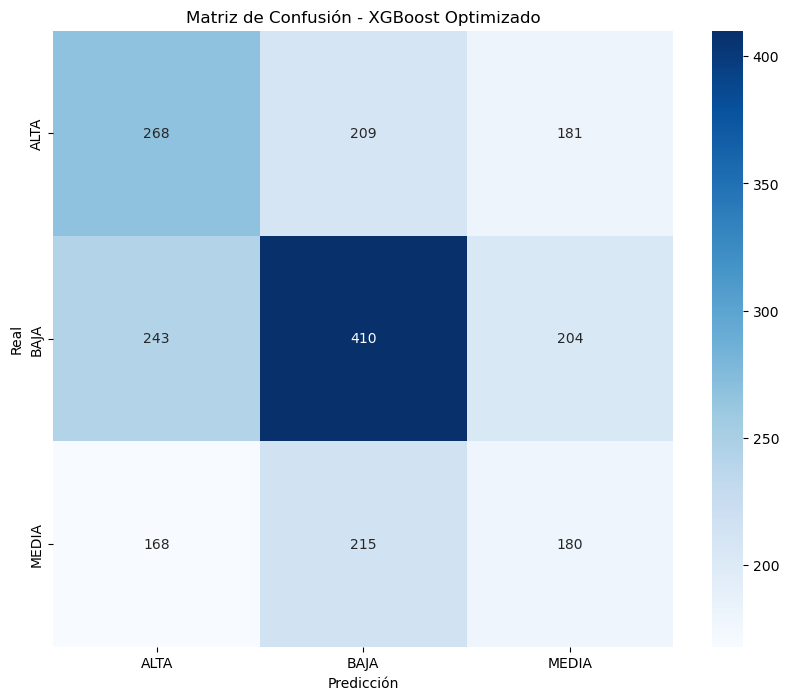

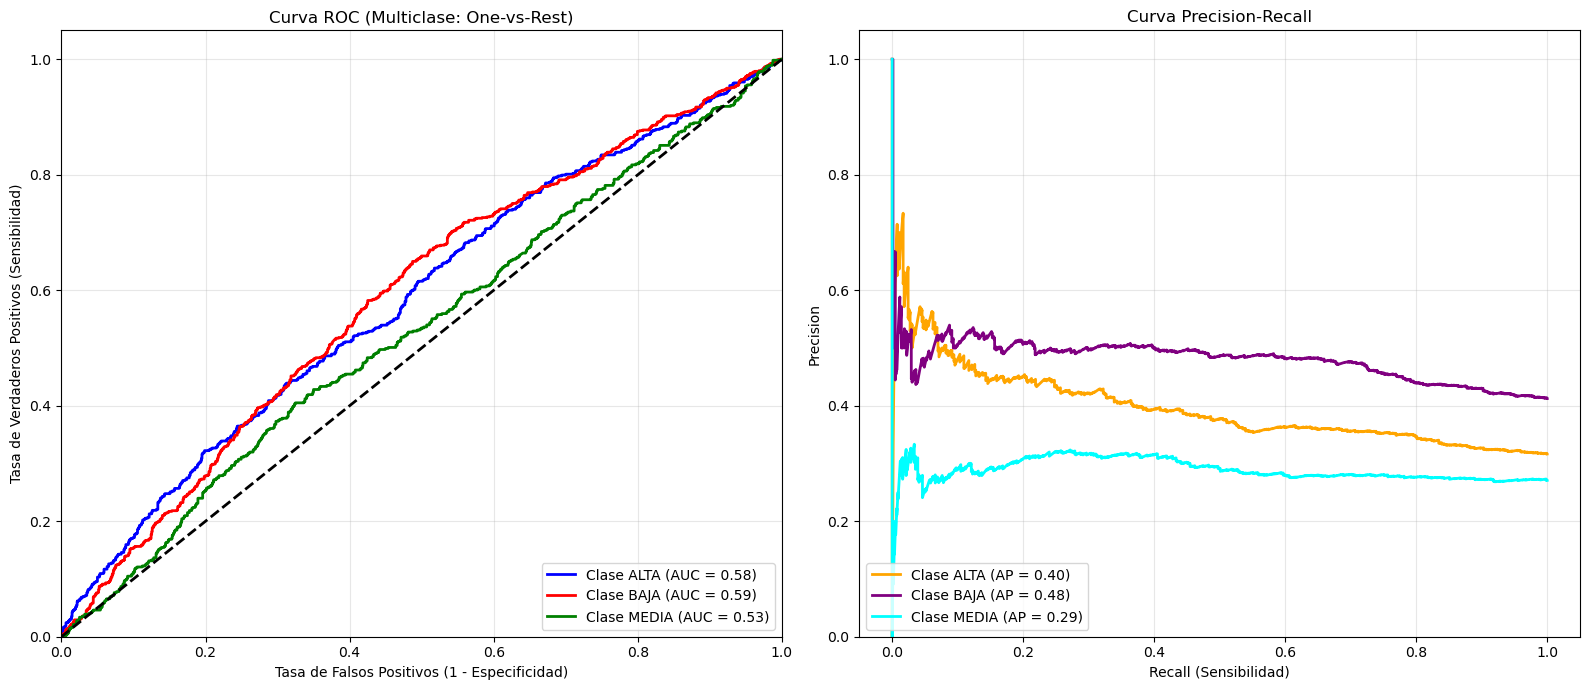


Generando curva de aprendizaje


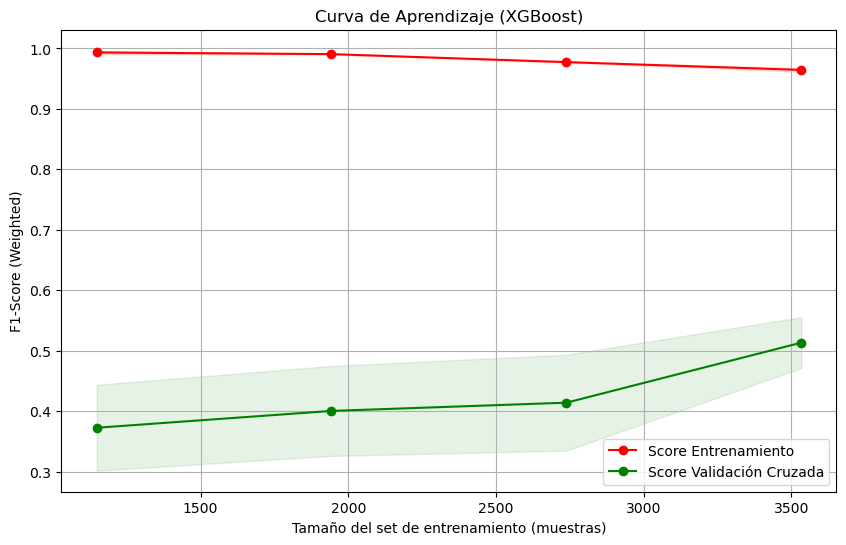

Diferencia final entre Train y Val: 0.4512
DIAGNÓSTICO: Posible Overfitting (Alta varianza).
Sugerencia: Aumentar regularización (reg_alpha/lambda), reducir max_depth o conseguir más datos.

Validación cruzada con el mejor modelo:
Precisión promedio: 0.518 (+/- 0.029)
F1-score promedio: 0.518 (+/- 0.028)


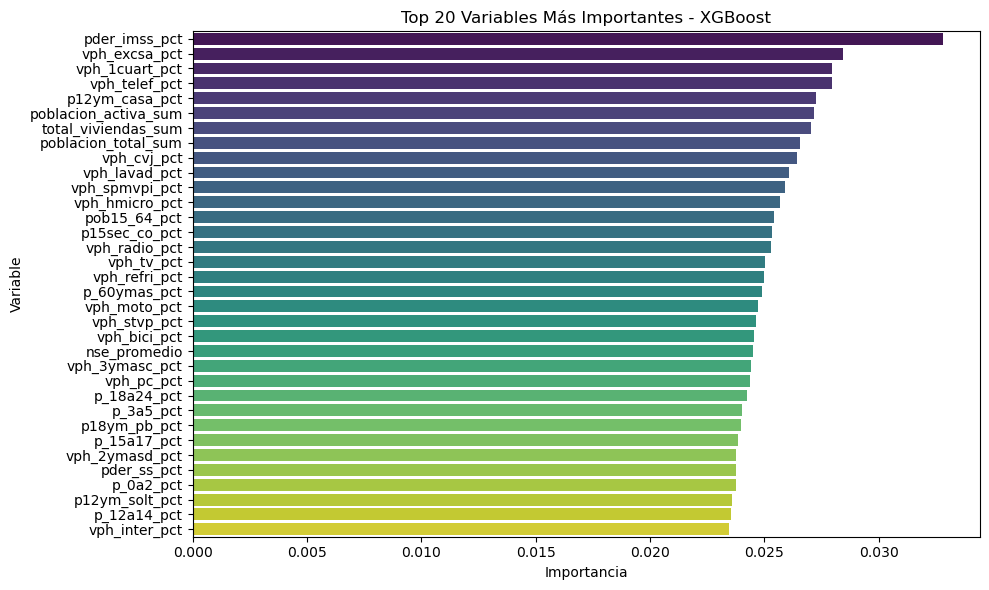


Importancia de variables:
                Variable  Importancia
26         pder_imss_pct     0.032788
6          vph_excsa_pct     0.028424
27        vph_1cuart_pct     0.027958
22         vph_telef_pct     0.027956
37        p12ym_casa_pct     0.027251
2   poblacion_activa_sum     0.027165
1    total_viviendas_sum     0.027051
3    poblacion_total_sum     0.026559
15           vph_cvj_pct     0.026440
19         vph_lavad_pct     0.026081
23        vph_spmvpi_pct     0.025896
20        vph_hmicro_pct     0.025694
35          pob15_64_pct     0.025419
28         p15sec_co_pct     0.025326
25         vph_radio_pct     0.025277
24            vph_tv_pct     0.025037
21         vph_refri_pct     0.024988
36          p_60ymas_pct     0.024906
17          vph_moto_pct     0.024710
13          vph_stvp_pct     0.024630
18          vph_bici_pct     0.024557
39          nse_promedio     0.024507
12        vph_3ymasc_pct     0.024421
14            vph_pc_pct     0.024365
34           p_18a24_pc

In [22]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
import multiprocessing  # <- Nuevo import
import warnings
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')


# Configura para usar todos los núcleos físicos (o menos si quieres dejar recursos libres)
n_cores = multiprocessing.cpu_count()  # Usará 20 en tu caso
os.environ['LOKY_MAX_CPU_COUNT'] = '16'  # Configura todos los núcleos

# os.environ['LOKY_MAX_CPU_COUNT'] = '16'
# Leer el archivo csv
#file_name = "./Datasets/Dataset-Entrenamiento.csv"
#df = pd.read_csv(file_name, encoding='latin-1', low_memory=False)
df = df_nse.copy()
# Función para limpiar y convertir columnas a numérico
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace('\n', ' ')

# Columnas para agrupar (localidad / manzana)
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']  # 'ageb','mza']
columnas_grupo = [col for col in columnas_grupo if col in df.columns]
 

# Variables que se deben sumar antes de calcular porcentaje
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir las variables antes de sumar (solo variables presentes)
vars_present = [var for var in variables_a_sumar if var in df.columns]

# Convertir y coercionar a numérico; rellenar NaN con 0 para evitar int + str durante sumas
for var in vars_present:
    df[var] = limpiar_y_convertir(df[var])
df[vars_present] = df[vars_present].apply(pd.to_numeric, errors='coerce').fillna(0)

# Sumar variables por localidad (ahora todas son numéricas)
df_sums = df.groupby(columnas_grupo)[vars_present].sum().reset_index()

# Asegurar que las columnas usadas como denominadores son numéricas y sin valores no válidos
for col in ['tvivparhab', 'pea', 'pobtot','graproes','uni_eco', 'prom_hnv']:
    if col in df.columns:
        # eliminar caracteres problemáticos, convertir y rellenar 0
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('*', '', regex=False), errors='coerce').fillna(0)

# Sumar variables totales para denominadores (incluye promedio de 'graproes')
df_totales = df.groupby(columnas_grupo).agg({
    'graproes': 'mean',
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum',
    'uni_eco': 'sum',
    'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom',
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum',
    'prom_hnv': 'hnv_prom'
})

# Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Calcular porcentajes con base en totales agrupados
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_total_sum']
    else:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['total_viviendas_sum']

# Agregar promedio numérico de NSE por localidad si existe la columna 'nse'
if 'nse' in df.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df['nse'] = pd.Categorical(df['nse'], categories=orden_clases, ordered=True)
    df['nse_num'] = df['nse'].cat.codes
    df_nse_prom = df.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom = df_nse_prom.rename(columns={'nse_num': 'nse_promedio'})
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# Seleccionar variables para modelo: usar solo las variables porcentuales y 'nse_promedio' si existe
variables_pct = [col for col in df_totales.columns if col.endswith('_pct') or col.endswith('_sum') or col.endswith('_prom')]
if 'nse_promedio' in df_totales.columns:
    variables_pct.append('nse_promedio')

# El target 'clasificacion' debe estar en df (agrupar si es necesario)
if 'clasificacion' not in df.columns:
    raise ValueError("La columna 'clasificacion' no está en el dataset original.")
# Agrupar clasificación por localidad (mayoría o modo)
df_clasificacion = df.groupby(columnas_grupo)['clasificacion'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()



# Unir con df_totales
df_model = pd.merge(df_totales, df_clasificacion, on=columnas_grupo, how='left')
 
# Crear ratios/interacciones importantes
df_model['ratio_viviendas_persona'] = df_model['total_viviendas_sum'] / df_model['poblacion_total_sum']

# Dependencia Economica
df_model['dependencia_economica'] = (df_model['p_0a2_pct'] + df_model['p_3a5_pct'] + 
                                    df_model['p_60ymas_pct']) / df_model['pob15_64_pct']
# Crear ratios/interacciones importantes (ahora que df_model existe)
df_model['ratio_viviendas_persona'] = df_model['total_viviendas_sum'] / df_model['poblacion_total_sum']
# Preparar datos para modelo
X = df_model[variables_pct].copy()
y = df_model['clasificacion'].astype('category')

# Reemplazar inf y NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

 
# Dividir en entrenamiento y prueba
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)


smote_tomek = SMOTETomek(random_state=42)
X_train, y_train = smote_tomek.fit_resample(X_train_orig, y_train_orig)


print("\n" + "="*40)
print("DISTRIBUCIÓN DE ETIQUETAS")
print("="*40)

# Obtener la distribución antes del split
unique, counts = np.unique(y_encoded, return_counts=True)
class_names = label_encoder.classes_

for i, (cls_num, cls_name) in enumerate(zip(unique, class_names)):
    print(f"Etiqueta {cls_num} ({cls_name}): {counts[i]:,}")

print(f"Total de registros: {len(y_encoded):,}")

# Para problemas binarios, calcular proporción de clase positiva
if len(class_names) == 2:
    if 1 in unique:
        idx_1 = np.where(unique == 1)[0][0]
        proporcion_positiva = counts[idx_1] / len(y_encoded)
        print(f"Proporción positiva: {proporcion_positiva:.4f}")

print(f"Tamaño del dataset: X{X.shape}, y({len(y_encoded)},)")

print("\n" + "="*40)
print("DISTRIBUCIÓN EN TRAIN/TEST ORIGINAL")
print("="*40)

# Distribución en train original (antes de SMOTE)
unique_train_orig, counts_train_orig = np.unique(y_train_orig, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("TRAIN ORIGINAL (antes de balanceo):")
for cls_num, cls_name, count in zip(unique_train_orig, class_names, counts_train_orig):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\nTEST:")
for cls_num, cls_name, count in zip(unique_test, class_names, counts_test):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\n" + "="*40)
print("DISTRIBUCIÓN EN TRAIN/TEST DESPUÉS DE SMOTE-TOMEK")
print("="*40)

# Distribución en train después de SMOTE-Tomek
unique_train_smote, counts_train_smote = np.unique(y_train, return_counts=True)

print("TRAIN (después de SMOTE-Tomek):")
for cls_num, cls_name, count in zip(unique_train_smote, class_names, counts_train_smote):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\nTEST (sin cambios):")
for cls_num, cls_name, count in zip(unique_test, class_names, counts_test):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")


# Configuración inicial de XGBoost con parámetros conservadores para evitar overfitting
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Probar estos hiperparámetros:
best_params_fixed = {
    'colsample_bytree': 0.9,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,
    'n_estimators': 250,
    'subsample': 0.8,
    'reg_alpha': 0,      # Agregados de tu nueva grid
    'reg_lambda': 1      # Agregados de tu nueva grid
}

# Métrica de evaluación (F1 weighted)
# Métrica de evaluación (F1 weighted)
scorer = make_scorer(f1_score, average='weighted')

# Asegurar que GridSearch reciba listas/arrays aunque los valores sean únicos
param_grid_fixed = {k: v if isinstance(v, (list, tuple, np.ndarray)) else [v] for k, v in best_params_fixed.items()}
 
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_fixed,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# ¡CORRECCIÓN! Debes llamar a .fit() para que GridSearch entrene los modelos
# y determine el mejor estimador.
print("Iniciando búsqueda de hiperparámetros con GridSearchCV...")
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Predecir y evaluar
y_pred = best_xgb.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calcular probabilidades para métricas ROC/AUC
y_pred_proba = best_xgb.predict_proba(X_test)

# Obtener probabilidades para la clase positiva (asumiendo clase 1 como positiva)
# En problemas multiclase necesitamos adaptar para cada clase
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Si es problema binario
if len(label_encoder.classes_) == 2:
    y_pred_proba_pos = y_pred_proba[:, 1]
    y_test_bin = y_test
    
    # Calcular métricas
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba_pos)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
else:
    # Para multiclase: usar One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    
    # Calcular ROC AUC para multiclase
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("MÉTRICAS DETALLADAS DEL MODELO")
print("="*60)
print(f"roc_auc: {roc_auc:.4f}")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")
print("="*60)

# Calcular matriz de confusión detallada
conf_matrix = confusion_matrix(y_test, y_pred)

# Extraer valores de la matriz de confusión
if len(label_encoder.classes_) == 2:
    TN, FP, FN, TP = conf_matrix.ravel()
    print(f"\nMATRIZ DE CONFUSIÓN DETALLADA:")
    print(f"Verdaderos Negativos (TN): {TN}")
    print(f"Falsos Positivos (FP):     {FP}")
    print(f"Falsos Negativos (FN):     {FN}")
    print(f"Verdaderos Positivos (TP): {TP}")
else:
    print(f"\nMatriz de confusión (multiclase - forma {conf_matrix.shape}):")
    print(conf_matrix)

# Calcular threshold óptimo para problemas binarios
if len(label_encoder.classes_) == 2:
    from sklearn.metrics import roc_curve
    import numpy as np
    
    # Threshold basado en ROC (Youden's J statistic)
    fpr, tpr, thresholds_roc = roc_curve(y_test_bin, y_pred_proba_pos)
    j_scores = tpr - fpr
    optimal_idx_roc = np.argmax(j_scores)
    optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
    
    # Threshold basado en F1-score
    f1_scores = []
    thresholds_f1 = np.arange(0.1, 0.9, 0.01)
    
    for threshold in thresholds_f1:
        y_pred_thresh = (y_pred_proba_pos >= threshold).astype(int)
        f1_val = f1_score(y_test_bin, y_pred_thresh)
        f1_scores.append(f1_val)
    
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = thresholds_f1[optimal_idx_f1]
    
    print(f"\nTHRESHOLDS ÓPTIMOS:")
    print(f"Threshold óptimo (ROC-based): {optimal_threshold_roc:.4f}")
    print(f"Threshold óptimo (F1-based): {optimal_threshold_f1:.4f}")

print("="*60)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - XGBoost Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ==============================================================================
# GRÁFICOS DE CURVAS ROC Y PRECISION-RECALL
# ==============================================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Preparar datos (Binarizar etiquetas para Multiclase)
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Si es binario, label_binarize devuelve una columna, necesitamos forma (n_samples, 1) o (n_samples, 2)
# Ajuste para consistencia si es binario estricto
if n_classes == 2:
    # Para 2 clases, y_test_bin es vector columna. 
    # ROC curve necesita y_true y y_score de la clase positiva.
    # Vamos a tratarlo genéricamente iterando sobre las clases.
    # Re-binarizamos explícitamente a 2 columnas para el bucle
    y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

# 2. Configurar la figura (2 subplots: Izquierda ROC, Derecha PR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Colores para las clases
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])

# --- GRAFICO 1: CURVA ROC ---
for i, color in zip(range(n_classes), colors):
    # Calcular FPR y TPR
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plotear
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'Clase {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2) # Línea diagonal de azar
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax1.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
ax1.set_title('Curva ROC (Multiclase: One-vs-Rest)')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# --- GRAFICO 2: CURVA PRECISION-RECALL ---
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'Clase {label_encoder.classes_[i]} (AP = {average_precision:.2f})')

ax2.set_xlabel('Recall (Sensibilidad)')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend(loc="lower left")
ax2.grid(alpha=0.3)
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# ==============================================================================
# GRÁFICO DE CURVA DE APRENDIZAJE (LEARNING CURVE)
# ==============================================================================
from sklearn.model_selection import learning_curve

print("\nGenerando curva de aprendizaje")

# Configuración de la curva
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_xgb,
    X=X_train,           # Usamos los datos de entrenamiento (balanceados)
    y=y_train,
    cv=3,                # 3 folds para que sea más rápido
    n_jobs=-1,           # Usar todos los núcleos
    train_sizes=np.linspace(0.1, 1.0, 5), # Evaluar en 5 puntos del tamaño del dataset
    scoring='f1_weighted' # Métrica consistente con tu GridSearch
)

# Calcular promedios y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score Validación Cruzada")

# Dibujar bandas de varianza (desviación estándar)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.title("Curva de Aprendizaje (XGBoost)")
plt.xlabel("Tamaño del set de entrenamiento (muestras)")
plt.ylabel("F1-Score (Weighted)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================================================================
# INTERPRETACIÓN AUTOMÁTICA
# ==============================================================================
gap = train_mean[-1] - test_mean[-1]
print(f"Diferencia final entre Train y Val: {gap:.4f}")

if train_mean[-1] > 0.95 and test_mean[-1] < 0.85:
    print("DIAGNÓSTICO: Posible Overfitting (Alta varianza).")
    print("Sugerencia: Aumentar regularización (reg_alpha/lambda), reducir max_depth o conseguir más datos.")
elif train_mean[-1] < 0.70 and test_mean[-1] < 0.70:
    print("DIAGNÓSTICO: Posible Underfitting (Alto sesgo).")
    print("Sugerencia: Hacer el modelo más complejo (más depth, menos regularización) o mejorar las features.")
else:
    print("DIAGNÓSTICO: El modelo parece equilibrado.")
    if test_mean[-1] < train_mean[-1]:
        print("Aún hay un pequeño margen de mejora si consigues más datos.")

# Validación cruzada con el mejor modelo
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_accuracy = cross_val_score(best_xgb, X_train, y_train, cv=skf, scoring='accuracy')
scores_f1 = cross_val_score(best_xgb, X_train, y_train, cv=skf, scoring='f1_weighted')

print("\nValidación cruzada con el mejor modelo:")
print(f"Precisión promedio: {scores_accuracy.mean():.3f} (+/- {scores_accuracy.std() * 2:.3f})")
print(f"F1-score promedio: {scores_f1.mean():.3f} (+/- {scores_f1.std() * 2:.3f})")

# Importancia de variables
importancias = best_xgb.feature_importances_
importancias_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancias_df.head(34), palette="viridis")
plt.title("Top 20 Variables Más Importantes - XGBoost")
plt.tight_layout()
plt.show()

print("\nImportancia de variables:")
print(importancias_df.head(34))

# Guardar modelo
modelo_path = "Modelos A\\modelo_xgboost_optimizado_update.pkl"
joblib.dump(best_xgb, modelo_path)
print(f"\nModelo guardado en: {modelo_path}")

# Guardar el label encoder también
encoder_path = "Modelos A\label_encoder_update.pkl"
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder guardado en: {encoder_path}")



## Modelo Aplicado a todos los municipios

In [23]:
import pandas as pd
import numpy as np
import joblib
import multiprocessing
import os
import warnings

warnings.filterwarnings('ignore')

# 1. Configurar núcleos
n_cores = multiprocessing.cpu_count()
os.environ['LOKY_MAX_CPU_COUNT'] = str(n_cores)

# 2. Cargar modelo y label encoder
modelo_path = 'Modelos A\\modelo_xgboost_optimizado_update.pkl'
label_encoder_path = 'Modelos A\\label_encoder_update.pkl'

if not os.path.exists(modelo_path) or not os.path.exists(label_encoder_path):
    raise FileNotFoundError("Asegúrate de tener 'modelo_xgboost_optimizado_update.pkl' y 'label_encoder_update.pkl' en el directorio.")
model = joblib.load(modelo_path)
label_encoder = joblib.load(label_encoder_path)
print("Modelo y LabelEncoder cargados exitosamente")

# 3. Cargar y preparar nuevos datos
df_nuevo = pd.read_csv("./Datasets/07.NSE.csv")
df_nuevo.columns = df_nuevo.columns.str.strip().str.lower().str.replace('\n', ' ')

# 4. Función de limpieza (Misma lógica del entrenamiento)
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# 5. Columnas para agrupar
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']
columnas_grupo = [col for col in columnas_grupo if col in df_nuevo.columns]

# 6. Variables a procesar (Basado en el nuevo modelo)
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir variables de suma
for var in variables_a_sumar:
    if var in df_nuevo.columns:
        df_nuevo[var] = limpiar_y_convertir(df_nuevo[var])

# 7. Realizar agrupaciones (Sumas, Promedios y Totales)
# Primero las sumas de variables específicas
df_sums = df_nuevo.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()

# Limpiar variables para denominadores y promedios
cols_especiales = ['graproes', 'tvivparhab', 'pea', 'pobtot', 'uni_eco', 'prom_hnv']
for col in cols_especiales:
    if col in df_nuevo.columns:
        df_nuevo[col] = limpiar_y_convertir(df_nuevo[col])

# Agregaciones de totales y promedios
df_totales = df_nuevo.groupby(columnas_grupo).agg({
    'graproes': 'mean',
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum',
    'uni_eco': 'sum',
    'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom',
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum',
    'prom_hnv': 'hnv_prom'
})

# Unir sumas y totales
df_proc = pd.merge(df_sums, df_totales, on=columnas_grupo)

# 8. Calcular porcentajes (_pct)
for var in variables_a_sumar:
    if var not in df_proc.columns:
        continue
    
    # Denominador según el tipo de variable (Lógica exacta del modelo de entrenamiento)
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        denominador = df_proc['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        denominador = df_proc['poblacion_total_sum']
    else:
        denominador = df_proc['total_viviendas_sum']
    
    df_proc[var + '_pct'] = df_proc[var] * 100 / denominador.replace(0, np.nan)

# 9. Agregar NSE promedio (si está disponible)
if 'nse' in df_nuevo.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df_nuevo['nse'] = pd.Categorical(df_nuevo['nse'], categories=orden_clases, ordered=True)
    df_nuevo['nse_num'] = df_nuevo['nse'].cat.codes
    df_nse_prom = df_nuevo.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom.rename(columns={'nse_num': 'nse_promedio'}, inplace=True)
    df_proc = pd.merge(df_proc, df_nse_prom, on=columnas_grupo, how='left')

# 10. Crear Ratios e Interacciones (Nuevas variables del modelo)
df_proc['ratio_viviendas_persona'] = df_proc['total_viviendas_sum'] / df_proc['poblacion_total_sum'].replace(0, np.nan)

# Dependencia Económica
df_proc['dependencia_economica'] = (df_proc['p_0a2_pct'] + df_proc['p_3a5_pct'] + 
                                   df_proc['p_60ymas_pct']) / df_proc['pob15_64_pct'].replace(0, np.nan)

# 11. Alinear con las columnas que el modelo espera
features_modelo = model.feature_names_in_
X_pred = df_proc.reindex(columns=features_modelo)

# 12. Limpieza final de valores infinitos o nulos
X_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# Rellenar con 0 para ser consistente con el relleno de entrenamiento: X.fillna(0, inplace=True)
X_pred.fillna(0, inplace=True)

# 13. Predecir
probabilidades = model.predict_proba(X_pred)
clases_nombres = label_encoder.classes_

# 14. Crear DataFrame de resultados
resultados = df_proc[columnas_grupo].copy()
for i, clase in enumerate(clases_nombres):
    resultados[f'prob_{clase}'] = probabilidades[:, i]

# Clasificación final
resultados['clasificacion_predicha'] = label_encoder.inverse_transform(np.argmax(probabilidades, axis=1))
resultados['prob_maxima'] = np.max(probabilidades, axis=1)

# 15. Exportar
output_path = r"./Predicciones/tasa-de-autorizacion-por-municipio.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
resultados.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\nProceso completado.")
print(f"Resultados guardados en: {output_path}")
print(f"Total de registros procesados: {len(resultados)}")
print(f"Muestra de resultados:\n", resultados[columnas_grupo + ['clasificacion_predicha', 'prob_maxima']].head())


# ==============================================================================
# ANÁLISIS DE DISTRIBUCIÓN POR ENTIDAD Y MUNICIPIO
# ==============================================================================

print("\n" + "="*60)
print("RESUMEN DE COMPORTAMIENTO DEL MODELO")
print("="*60)

# 1. Distribución de Etiquetas por Entidad (¿Qué está prediciendo en cada estado?)
print("\n1. Distribución de clasificaciones por Entidad (Top 10):")
dist_entidad = resultados.groupby(['nom_ent', 'clasificacion_predicha']).size().unstack(fill_value=0)
# Calcular porcentajes para mejor interpretación
dist_entidad_pct = dist_entidad.div(dist_entidad.sum(axis=1), axis=0) * 100
print(dist_entidad_pct.head(10).round(2).astype(str) + '%')

# 2. Promedio de Probabilidades por Entidad (¿Qué tan seguro está el modelo en cada estado?)
print("\n2. Seguridad del modelo (Probabilidad promedio) por Entidad:")
prob_cols = [f'prob_{clase}' for clase in label_encoder.classes_]
avg_probs_ent = resultados.groupby('nom_ent')[prob_cols].mean()
print(avg_probs_ent.head(10).round(4))

# 3. Análisis a nivel Municipio (Agrupado por Entidad)
# Vamos a ver los 5 municipios con mayor probabilidad máxima (más seguros) 
# y los 5 con menor (donde el modelo duda más)
print("\n3. Top 5 Municipios con mayor certeza (Prob Máxima):")
municipios_seguros = resultados.groupby(['nom_ent', 'nom_mun'])['prob_maxima'].mean().sort_values(ascending=False).head(5)
print(municipios_seguros)

print("\n4. Top 5 Municipios con menor certeza (Donde el modelo tiene dudas):")
municipios_duda = resultados.groupby(['nom_ent', 'nom_mun'])['prob_maxima'].mean().sort_values(ascending=True).head(5)
print(municipios_duda)

# 5. Resumen General de Predicciones a nivel Nacional
print("\n5. Conteo Total Nacional de Predicciones:")
conteo_nacional = resultados['clasificacion_predicha'].value_counts()
conteo_nacional_pct = resultados['clasificacion_predicha'].value_counts(normalize=True) * 100
resumen_nac = pd.DataFrame({
    'Cantidad': conteo_nacional,
    'Porcentaje': conteo_nacional_pct.round(2).astype(str) + '%'
})
print(resumen_nac)

 
 

Modelo y LabelEncoder cargados exitosamente

Proceso completado.
Resultados guardados en: ./Predicciones/tasa-de-autorizacion-por-municipio.csv
Total de registros procesados: 28124
Muestra de resultados:
           nom_ent         nom_mun         nom_loc cveid_enti  \
0  Aguascalientes  Aguascalientes  Aguascalientes     1000-1   
1  Aguascalientes  Aguascalientes  Aguascalientes     1002-1   
2  Aguascalientes  Aguascalientes  Aguascalientes     1003-1   
3  Aguascalientes  Aguascalientes  Aguascalientes     1004-1   
4  Aguascalientes  Aguascalientes  Aguascalientes     1005-1   

                     nombre clasificacion_predicha  prob_maxima  
0     MISION DE SANTIAGO  I                   BAJA     0.593210  
1                  LA SALUD                   ALTA     0.491274  
2  RINCONADA DE LA ASUNCION                   BAJA     0.535074  
3                 AUSTRALIS                   BAJA     0.534496  
4              SOL NACIENTE                  MEDIA     0.722427  

RESUMEN DE CO

## Clasificación de Score de Riesgo

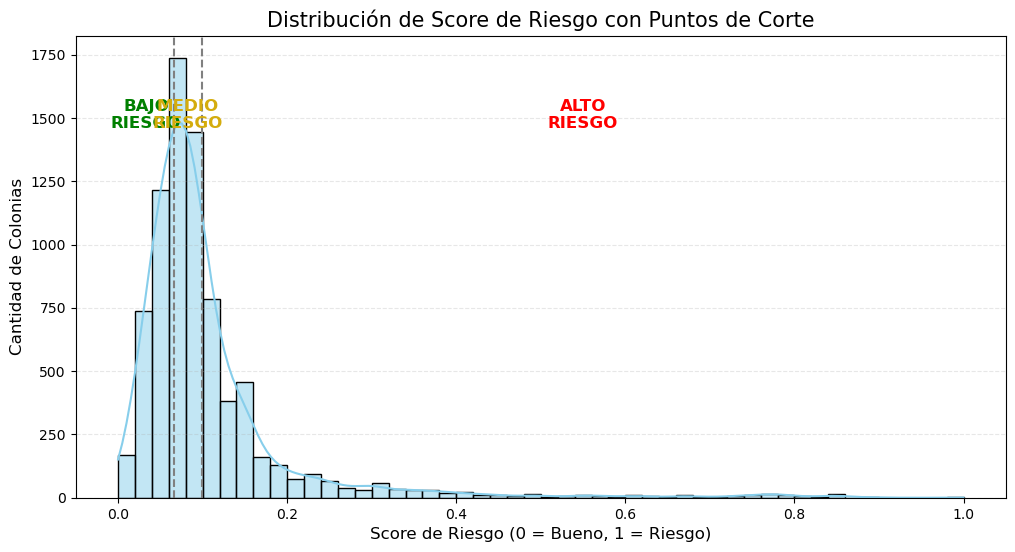

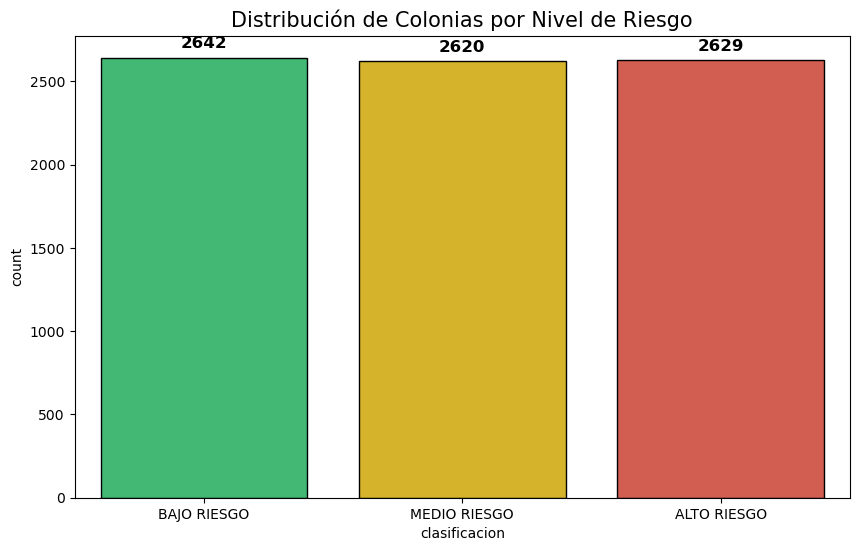


RESUMEN DE PROCESAMIENTO
Rangos calculados:
- Bajo Riesgo: 0.0000 a 0.0664
- Medio Riesgo: 0.0664 a 0.0991
- Alto Riesgo: > 0.0991
--------------------------------------------------
Conteo de registros final en df_final:
clasificacion
ALTO RIESGO     64594
MEDIO RIESGO    56092
BAJO RIESGO     40610
Name: count, dtype: int64


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# 1. Carga y Limpieza inicial
df = pd.read_excel("buró_imor60y90_xColonia.xlsx")

# Definir columnas de interés
cols_to_scale = ['%Buró Externo EB', 'IMOR EB 60 días', 'IMOR EB 90 días']

# Asegurar que las columnas sean numéricas y manejar valores nulos antes de procesar
for col in cols_to_scale:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 2. Escalar y Calcular el Score de Riesgo
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[cols_to_scale])

# Calcular el Score (0 = Excelente pagador / 1 = Riesgo máximo)
df['Score_Riesgo'] = (df_scaled[:, 0] * 0.30) + \
                     (df_scaled[:, 1] * 0.30) + \
                     (df_scaled[:, 2] * 0.40)

# ---------------------------------------------------------
# 3. DEFINICIÓN DE CATEGORÍAS (Lógica corregida)
# ---------------------------------------------------------
# qcut asigna etiquetas de menor a mayor valor:
# Score bajo (0 a 0.33) -> BAJO RIESGO
# Score alto (0.66 a 1.0) -> ALTO RIESGO
mis_etiquetas = ['BAJO RIESGO', 'MEDIO RIESGO', 'ALTO RIESGO']
mis_colores = {'BAJO RIESGO': '#2ecc71', 'MEDIO RIESGO': '#f1c40f', 'ALTO RIESGO': '#e74c3c'}

df['clasificacion'] = pd.qcut(df['Score_Riesgo'], q=3, labels=mis_etiquetas)

# --- Cálculo de puntos de corte para visualización ---
q1 = df['Score_Riesgo'].quantile(1/3)
q2 = df['Score_Riesgo'].quantile(2/3)

# ---------------------------------------------------------
# 4. VISUALIZACIÓN 1: Distribución y Cortes
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['Score_Riesgo'], bins=50, kde=True, color='skyblue', edgecolor='black')

# Líneas divisoras
plt.axvline(q1, color='gray', linestyle='--', linewidth=1.5)
plt.axvline(q2, color='gray', linestyle='--', linewidth=1.5)

# Etiquetas de zona en el gráfico
plt.text(q1/2, plt.ylim()[1]*0.8, 'BAJO\nRIESGO', color='green', fontsize=12, ha='center', fontweight='bold')
plt.text((q1+q2)/2, plt.ylim()[1]*0.8, 'MEDIO\nRIESGO', color='#d4ac0d', fontsize=12, ha='center', fontweight='bold')
plt.text((q2 + df['Score_Riesgo'].max())/2, plt.ylim()[1]*0.8, 'ALTO\nRIESGO', color='red', fontsize=12, ha='center', fontweight='bold')

plt.title('Distribución de Score de Riesgo con Puntos de Corte', fontsize=15)
plt.xlabel('Score de Riesgo (0 = Bueno, 1 = Riesgo)', fontsize=12)
plt.ylabel('Cantidad de Colonias', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# ---------------------------------------------------------
# 5. VISUALIZACIÓN 2: Conteo por Categoría
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='clasificacion', data=df, palette=mis_colores, edgecolor='black', order=mis_etiquetas)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=12, fontweight='bold')

plt.title('Distribución de Colonias por Nivel de Riesgo', fontsize=15)
plt.show()

# ---------------------------------------------------------
# 6. INTEGRACIÓN CON NSE (Merge)
# ---------------------------------------------------------
# Cargar NSE
df_nse = pd.read_csv("./Datasets/07.NSE.csv")

# Asegurar que la llave de unión sea del mismo tipo (ej. string)
df['CVEID_ENTI'] = df['CVEID_ENTI'].astype(str)
df_nse['CVEID_ENTI'] = df_nse['CVEID_ENTI'].astype(str)

# Merge
df_nse = df_nse.merge(
    df[['CVEID_ENTI', 'clasificacion', 'Score_Riesgo']],
    on='CVEID_ENTI',
    how='inner'
)

# Resumen final en consola
print("\n" + "="*50)
print("RESUMEN DE PROCESAMIENTO")
print("="*50)
print(f"Rangos calculados:")
print(f"- Bajo Riesgo: 0.0000 a {q1:.4f}")
print(f"- Medio Riesgo: {q1:.4f} a {q2:.4f}")
print(f"- Alto Riesgo: > {q2:.4f}")
print("-"*50)
print("Conteo de registros final en df_final:")
print(df_nse['clasificacion'].value_counts())
print("="*50)

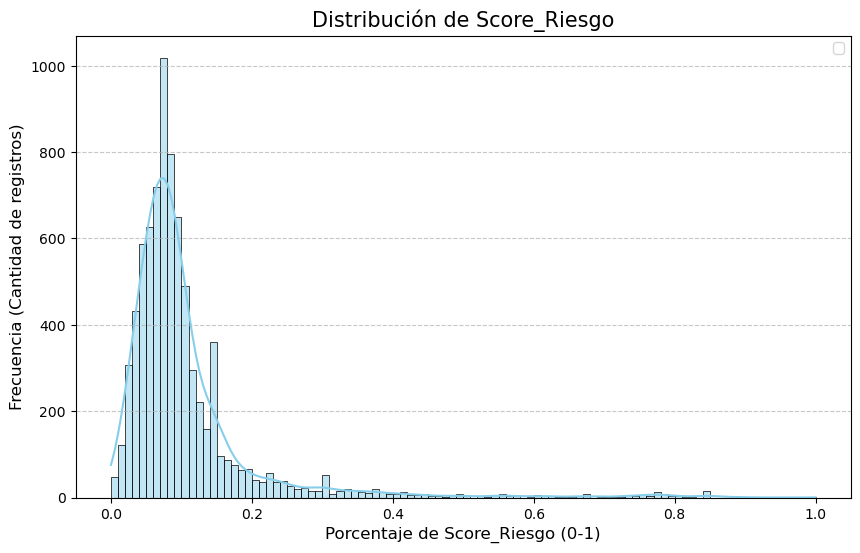

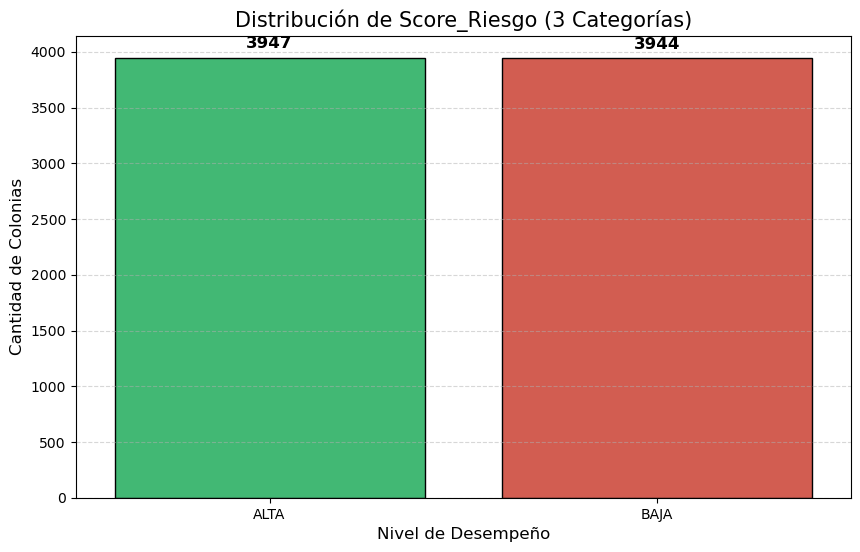

Conteo por categoría:
clasificacion
ALTA    3947
BAJA    3944
Name: count, dtype: int64
0
(161296, 255)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

df = pd.read_excel("buró_imor60y90_xColonia.xlsx")

 
# 2. (Opcional pero recomendado) Escalar de 0 a 1 para que todos pesen igual matemáticamente antes de aplicar tu criterio
scaler = MinMaxScaler()
cols_to_scale = ['%Buró Externo EB', 'IMOR EB 60 días', 'IMOR EB 90 días']
df_scaled = scaler.fit_transform(df[cols_to_scale])

# 3. Calcular el Score Ponderado
# Ajusta los pesos (0.3, 0.3, 0.4) según tu criterio de negocio
df['Score_Riesgo'] = (df_scaled[:, 0] * 0.30) + \
                               (df_scaled[:, 1] * 0.30) + \
                               (df_scaled[:, 2] * 0.40)

 
# 2. Crear el Histograma
plt.figure(figsize=(10, 6))

# Ajusté los bins a 50. Como ahora el rango es fijo de 0 a 100, 
# 1000 bins serían demasiados (barras muy finas). 50 o 100 es ideal.
sns.histplot(df['Score_Riesgo'], bins=100, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribución de Score_Riesgo', fontsize=15)
plt.xlabel('Porcentaje de Score_Riesgo (0-1)', fontsize=12)
plt.ylabel('Frecuencia (Cantidad de registros)', fontsize=12)

# Añadir una línea roja para marcar el tope
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 1. Limpieza y Tope al 100%

df['Score_Riesgo'] = pd.to_numeric(df['Score_Riesgo'], errors='coerce')
 

# ---------------------------------------------------------
# 2. DEFINICIÓN DE LAS 3 CATEGORÍAS (PERSONALIZABLE)
# ---------------------------------------------------------

mis_etiquetas = ['BAJA', 'ALTA']

# Colores para el gráfico (Rojo, Amarillo, Verde)
mis_colores = {'BAJA': '#e74c3c', 'MEDIA': '#f1c40f', 'ALTA': '#2ecc71'}

# Crear la columna de categorías

df['clasificacion'] = pd.qcut(df['Score_Riesgo'], q=2, labels=['ALTA', 'BAJA'])

# ---------------------------------------------------------
# 3. GRÁFICA DE LA DISTRIBUCIÓN
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Usamos countplot para contar categorías
ax = sns.countplot(x='clasificacion', data=df, palette=mis_colores, edgecolor='black')

plt.title('Distribución de Score_Riesgo (3 Categorías)', fontsize=15)
plt.xlabel('Nivel de Desempeño', fontsize=12)
plt.ylabel('Cantidad de Colonias', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Poner los números exactos encima de las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.show()


# Mostrar resumen en texto
print("Conteo por categoría:")
print(df['clasificacion'].value_counts().sort_index())


df_nse = pd.read_csv("./Datasets/07.NSE.csv")
df_nse.shape

df_nse = df_nse.merge(
    df[['CVEID_ENTI', 'clasificacion', 'Score_Riesgo']],
    on='CVEID_ENTI',
    how='inner'
)

print(df_nse['clasificacion'].isnull().sum())
print(df_nse.shape)


## Modelo Aplicado a todos los municipios


DISTRIBUCIÓN DE ETIQUETAS
Etiqueta 0 (ALTO RIESGO): 2,211
Etiqueta 1 (BAJO RIESGO): 1,737
Etiqueta 2 (MEDIO RIESGO): 2,133
Total de registros: 6,081
Tamaño del dataset: X(6081, 40), y(6081,)

DISTRIBUCIÓN EN TRAIN/TEST ORIGINAL
TRAIN ORIGINAL (antes de balanceo):
  Clase 0 (ALTO RIESGO): 1,547
  Clase 1 (BAJO RIESGO): 1,216
  Clase 2 (MEDIO RIESGO): 1,493

TEST:
  Clase 0 (ALTO RIESGO): 664
  Clase 1 (BAJO RIESGO): 521
  Clase 2 (MEDIO RIESGO): 640

DISTRIBUCIÓN EN TRAIN/TEST DESPUÉS DE SMOTE-TOMEK
TRAIN (después de SMOTE-Tomek):
  Clase 0 (ALTO RIESGO): 1,547
  Clase 1 (BAJO RIESGO): 1,216
  Clase 2 (MEDIO RIESGO): 1,493

TEST (sin cambios):
  Clase 0 (ALTO RIESGO): 664
  Clase 1 (BAJO RIESGO): 521
  Clase 2 (MEDIO RIESGO): 640
Iniciando búsqueda de hiperparámetros con GridSearchCV...
Fitting 3 folds for each of 1 candidates, totalling 3 fits

Mejores parámetros encontrados:
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estima

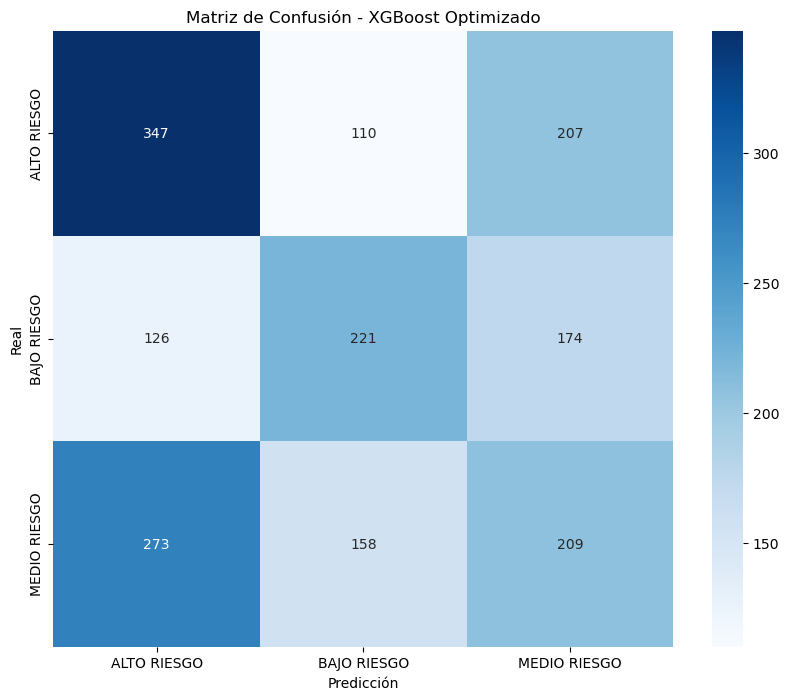

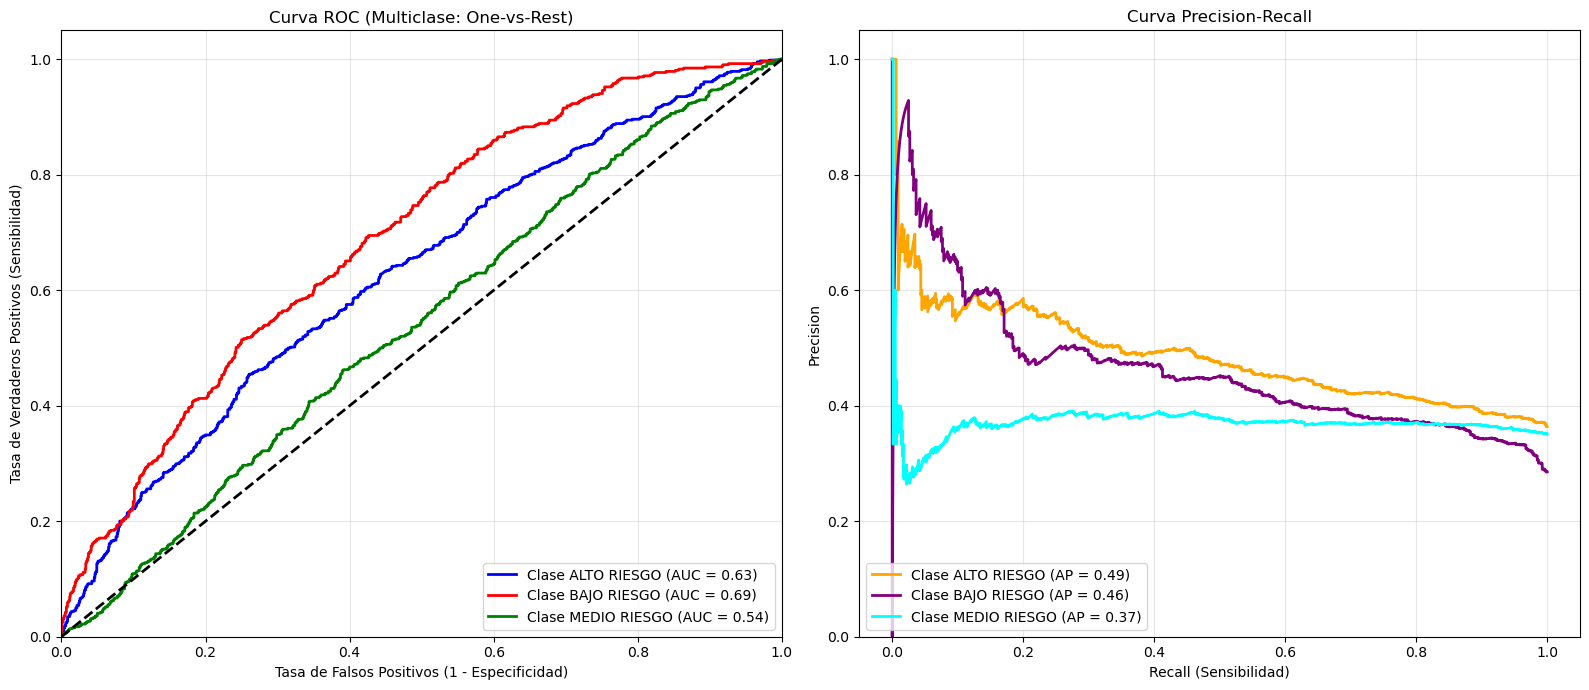


Generando curva de aprendizaje


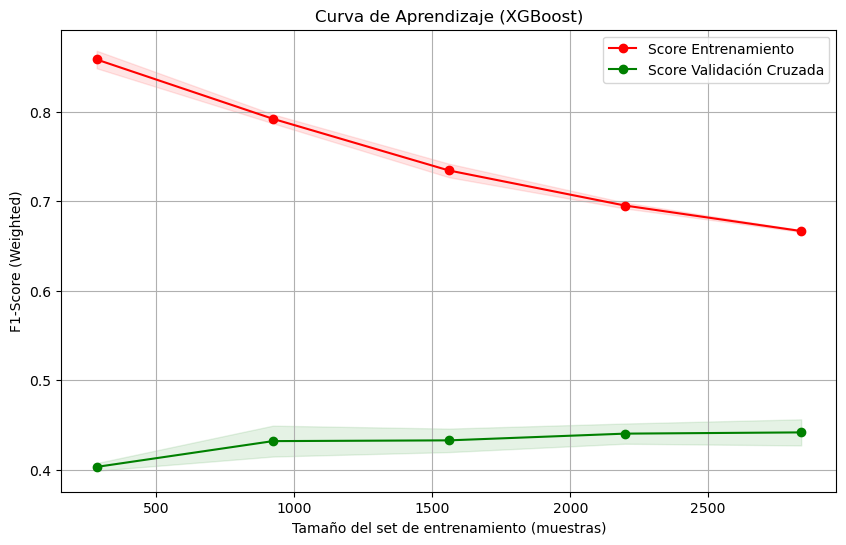

Diferencia final entre Train y Val: 0.2248
DIAGNÓSTICO: Posible Underfitting (Alto sesgo).
Sugerencia: Hacer el modelo más complejo (más depth, menos regularización) o mejorar las features.

Validación cruzada con el mejor modelo:
Precisión promedio: 0.449 (+/- 0.053)
F1-score promedio: 0.446 (+/- 0.053)


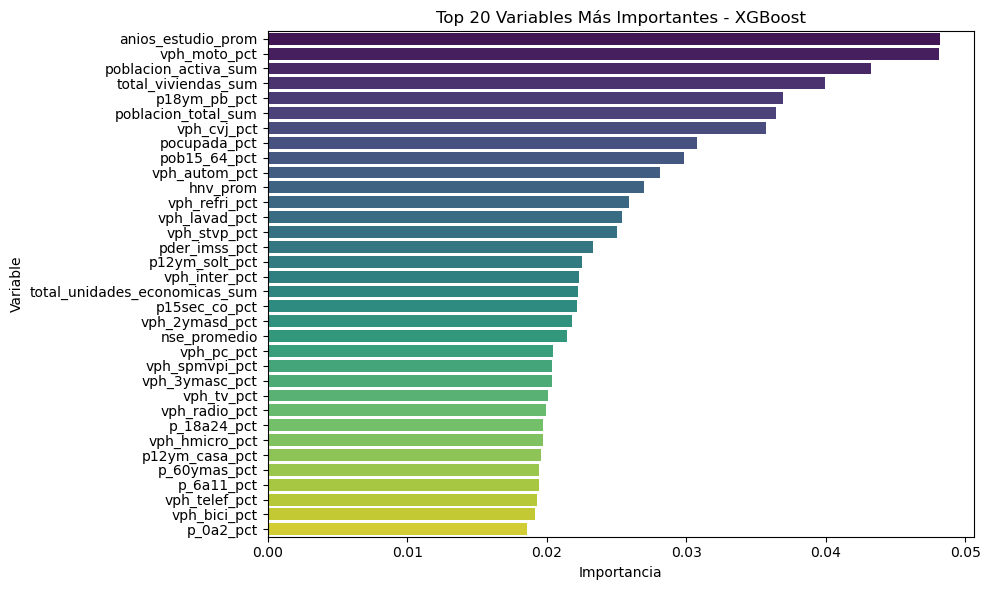


Importancia de variables:
                         Variable  Importancia
0              anios_estudio_prom     0.048219
17                   vph_moto_pct     0.048119
2            poblacion_activa_sum     0.043258
1             total_viviendas_sum     0.039935
11                   p18ym_pb_pct     0.036960
3             poblacion_total_sum     0.036414
15                    vph_cvj_pct     0.035718
9                    pocupada_pct     0.030759
35                   pob15_64_pct     0.029861
7                   vph_autom_pct     0.028150
5                        hnv_prom     0.026950
21                  vph_refri_pct     0.025863
19                  vph_lavad_pct     0.025413
13                   vph_stvp_pct     0.025008
26                  pder_imss_pct     0.023302
38                 p12ym_solt_pct     0.022544
8                   vph_inter_pct     0.022288
4   total_unidades_economicas_sum     0.022220
28                  p15sec_co_pct     0.022178
16                 vph_2ymasd_pct

In [14]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
import multiprocessing  # <- Nuevo import
import warnings
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')


# Configura para usar todos los núcleos físicos (o menos si quieres dejar recursos libres)
n_cores = multiprocessing.cpu_count()  # Usará 20 en tu caso
os.environ['LOKY_MAX_CPU_COUNT'] = '16'  # Configura todos los núcleos

# os.environ['LOKY_MAX_CPU_COUNT'] = '16'
# Leer el archivo csv
#file_name = "./Datasets/Dataset-Entrenamiento.csv"
#df = pd.read_csv(file_name, encoding='latin-1', low_memory=False)
df = df_nse.copy()
# Función para limpiar y convertir columnas a numérico
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# Limpiar nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace('\n', ' ')

# Columnas para agrupar (localidad / manzana)
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']  # 'ageb','mza']
#columnas_grupo = ['ageb']
columnas_grupo = [col for col in columnas_grupo if col in df.columns]
 

# Variables que se deben sumar antes de calcular porcentaje
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir las variables antes de sumar (solo variables presentes)
vars_present = [var for var in variables_a_sumar if var in df.columns]

# Convertir y coercionar a numérico; rellenar NaN con 0 para evitar int + str durante sumas
for var in vars_present:
    df[var] = limpiar_y_convertir(df[var])
df[vars_present] = df[vars_present].apply(pd.to_numeric, errors='coerce').fillna(0)

# Sumar variables por localidad (ahora todas son numéricas)
df_sums = df.groupby(columnas_grupo)[vars_present].sum().reset_index()

# Asegurar que las columnas usadas como denominadores son numéricas y sin valores no válidos
for col in ['tvivparhab', 'pea', 'pobtot','graproes','uni_eco', 'prom_hnv']:
    if col in df.columns:
        # eliminar caracteres problemáticos, convertir y rellenar 0
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('*', '', regex=False), errors='coerce').fillna(0)

# Sumar variables totales para denominadores (incluye promedio de 'graproes')
df_totales = df.groupby(columnas_grupo).agg({
    'graproes': 'mean',
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum',
    'uni_eco': 'sum',
    'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom',
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum',
    'prom_hnv': 'hnv_prom'
})

# Unir sumas y totales
df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

# Calcular porcentajes con base en totales agrupados
for var in variables_a_sumar:
    if var not in df_totales.columns:
        continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_total_sum']
    else:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['total_viviendas_sum']

# Agregar promedio numérico de NSE por localidad si existe la columna 'nse'
if 'nse' in df.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df['nse'] = pd.Categorical(df['nse'], categories=orden_clases, ordered=True)
    df['nse_num'] = df['nse'].cat.codes
    df_nse_prom = df.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom = df_nse_prom.rename(columns={'nse_num': 'nse_promedio'})
    df_totales = pd.merge(df_totales, df_nse_prom, on=columnas_grupo, how='left')

# Seleccionar variables para modelo: usar solo las variables porcentuales y 'nse_promedio' si existe
variables_pct = [col for col in df_totales.columns if col.endswith('_pct') or col.endswith('_sum') or col.endswith('_prom')]
if 'nse_promedio' in df_totales.columns:
    variables_pct.append('nse_promedio')

# El target 'clasificacion' debe estar en df (agrupar si es necesario)
if 'clasificacion' not in df.columns:
    raise ValueError("La columna 'clasificacion' no está en el dataset original.")
# Agrupar clasificación por localidad (mayoría o modo)
df_clasificacion = df.groupby(columnas_grupo)['clasificacion'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()


# Unir con df_totales
df_model = pd.merge(df_totales, df_clasificacion, on=columnas_grupo, how='left')

# Crear ratios/interacciones importantes
df_model['ratio_viviendas_persona'] = df_model['total_viviendas_sum'] / df_model['poblacion_total_sum']

# Dependencia Economica
df_model['dependencia_economica'] = (df_model['p_0a2_pct'] + df_model['p_3a5_pct'] + 
                                    df_model['p_60ymas_pct']) / df_model['pob15_64_pct']



# Crear ratios/interacciones importantes (ahora que df_model existe)
df_model['ratio_viviendas_persona'] = df_model['total_viviendas_sum'] / df_model['poblacion_total_sum']
# Preparar datos para modelo
X = df_model[variables_pct].copy()
y = df_model['clasificacion'].astype('category')

# Reemplazar inf y NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)


# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

 
# Dividir en entrenamiento y prueba
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

 
X_train, y_train = X_train_orig, y_train_orig
# smote_tomek = SMOTETomek(random_state=42)
# X_train, y_train = smote_tomek.fit_resample(X_train_orig, y_train_orig)
 
print("\n" + "="*40)
print("DISTRIBUCIÓN DE ETIQUETAS")
print("="*40)

# Obtener la distribución antes del split
unique, counts = np.unique(y_encoded, return_counts=True)
class_names = label_encoder.classes_

for i, (cls_num, cls_name) in enumerate(zip(unique, class_names)):
    print(f"Etiqueta {cls_num} ({cls_name}): {counts[i]:,}")

print(f"Total de registros: {len(y_encoded):,}")

# Para problemas binarios, calcular proporción de clase positiva
if len(class_names) == 2:
    if 1 in unique:
        idx_1 = np.where(unique == 1)[0][0]
        proporcion_positiva = counts[idx_1] / len(y_encoded)
        print(f"Proporción positiva: {proporcion_positiva:.4f}")

print(f"Tamaño del dataset: X{X.shape}, y({len(y_encoded)},)")

print("\n" + "="*40)
print("DISTRIBUCIÓN EN TRAIN/TEST ORIGINAL")
print("="*40)

# Distribución en train original (antes de SMOTE)
unique_train_orig, counts_train_orig = np.unique(y_train_orig, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("TRAIN ORIGINAL (antes de balanceo):")
for cls_num, cls_name, count in zip(unique_train_orig, class_names, counts_train_orig):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\nTEST:")
for cls_num, cls_name, count in zip(unique_test, class_names, counts_test):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\n" + "="*40)
print("DISTRIBUCIÓN EN TRAIN/TEST DESPUÉS DE SMOTE-TOMEK")
print("="*40)

# Distribución en train después de SMOTE-Tomek
unique_train_smote, counts_train_smote = np.unique(y_train, return_counts=True)

print("TRAIN (después de SMOTE-Tomek):")
for cls_num, cls_name, count in zip(unique_train_smote, class_names, counts_train_smote):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")

print("\nTEST (sin cambios):")
for cls_num, cls_name, count in zip(unique_test, class_names, counts_test):
    print(f"  Clase {cls_num} ({cls_name}): {count:,}")


# Configuración inicial de XGBoost con parámetros conservadores para evitar overfitting
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Probar estos hiperparámetros:
best_params_fixed = {
    'colsample_bytree': 0.5,
    'gamma': 0,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_child_weight': 10,
    'n_estimators': 250,
    'subsample': 0.8,
    'reg_alpha': 5,      # Agregados de tu nueva grid
    'reg_lambda': 10      # Agregados de tu nueva grid
}

# Métrica de evaluación (F1 weighted)
# Métrica de evaluación (F1 weighted)
scorer = make_scorer(f1_score, average='weighted')

# Asegurar que GridSearch reciba listas/arrays aunque los valores sean únicos
param_grid_fixed = {k: v if isinstance(v, (list, tuple, np.ndarray)) else [v] for k, v in best_params_fixed.items()}
 
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_fixed,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# ¡CORRECCIÓN! Debes llamar a .fit() para que GridSearch entrene los modelos
# y determine el mejor estimador.
print("Iniciando búsqueda de hiperparámetros con GridSearchCV...")
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

# Predecir y evaluar
y_pred = best_xgb.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calcular probabilidades para métricas ROC/AUC
y_pred_proba = best_xgb.predict_proba(X_test)

# Obtener probabilidades para la clase positiva (asumiendo clase 1 como positiva)
# En problemas multiclase necesitamos adaptar para cada clase
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Si es problema binario
if len(label_encoder.classes_) == 2:
    y_pred_proba_pos = y_pred_proba[:, 1]
    y_test_bin = y_test
    
    # Calcular métricas
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba_pos)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
else:
    # Para multiclase: usar One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
    
    # Calcular ROC AUC para multiclase
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("MÉTRICAS DETALLADAS DEL MODELO")
print("="*60)
print(f"roc_auc: {roc_auc:.4f}")
print(f"accuracy: {accuracy:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1: {f1:.4f}")
print("="*60)

# Calcular matriz de confusión detallada
conf_matrix = confusion_matrix(y_test, y_pred)

# Extraer valores de la matriz de confusión
if len(label_encoder.classes_) == 2:
    TN, FP, FN, TP = conf_matrix.ravel()
    print(f"\nMATRIZ DE CONFUSIÓN DETALLADA:")
    print(f"Verdaderos Negativos (TN): {TN}")
    print(f"Falsos Positivos (FP):     {FP}")
    print(f"Falsos Negativos (FN):     {FN}")
    print(f"Verdaderos Positivos (TP): {TP}")
else:
    print(f"\nMatriz de confusión (multiclase - forma {conf_matrix.shape}):")
    print(conf_matrix)

# Calcular threshold óptimo para problemas binarios
if len(label_encoder.classes_) == 2:
    from sklearn.metrics import roc_curve
    import numpy as np
    
    # Threshold basado en ROC (Youden's J statistic)
    fpr, tpr, thresholds_roc = roc_curve(y_test_bin, y_pred_proba_pos)
    j_scores = tpr - fpr
    optimal_idx_roc = np.argmax(j_scores)
    optimal_threshold_roc = thresholds_roc[optimal_idx_roc]
    
    # Threshold basado en F1-score
    f1_scores = []
    thresholds_f1 = np.arange(0.1, 0.9, 0.01)
    
    for threshold in thresholds_f1:
        y_pred_thresh = (y_pred_proba_pos >= threshold).astype(int)
        f1_val = f1_score(y_test_bin, y_pred_thresh)
        f1_scores.append(f1_val)
    
    optimal_idx_f1 = np.argmax(f1_scores)
    optimal_threshold_f1 = thresholds_f1[optimal_idx_f1]
    
    print(f"\nTHRESHOLDS ÓPTIMOS:")
    print(f"Threshold óptimo (ROC-based): {optimal_threshold_roc:.4f}")
    print(f"Threshold óptimo (F1-based): {optimal_threshold_f1:.4f}")

print("="*60)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - XGBoost Optimizado")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ==============================================================================
# GRÁFICOS DE CURVAS ROC Y PRECISION-RECALL
# ==============================================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. Preparar datos (Binarizar etiquetas para Multiclase)
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Si es binario, label_binarize devuelve una columna, necesitamos forma (n_samples, 1) o (n_samples, 2)
# Ajuste para consistencia si es binario estricto
if n_classes == 2:
    # Para 2 clases, y_test_bin es vector columna. 
    # ROC curve necesita y_true y y_score de la clase positiva.
    # Vamos a tratarlo genéricamente iterando sobre las clases.
    # Re-binarizamos explícitamente a 2 columnas para el bucle
    y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

# 2. Configurar la figura (2 subplots: Izquierda ROC, Derecha PR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Colores para las clases
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])

# --- GRAFICO 1: CURVA ROC ---
for i, color in zip(range(n_classes), colors):
    # Calcular FPR y TPR
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plotear
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'Clase {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=2) # Línea diagonal de azar
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
ax1.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
ax1.set_title('Curva ROC (Multiclase: One-vs-Rest)')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# --- GRAFICO 2: CURVA PRECISION-RECALL ---
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    average_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'Clase {label_encoder.classes_[i]} (AP = {average_precision:.2f})')

ax2.set_xlabel('Recall (Sensibilidad)')
ax2.set_ylabel('Precision')
ax2.set_title('Curva Precision-Recall')
ax2.legend(loc="lower left")
ax2.grid(alpha=0.3)
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# ==============================================================================
# GRÁFICO DE CURVA DE APRENDIZAJE (LEARNING CURVE)
# ==============================================================================
from sklearn.model_selection import learning_curve

print("\nGenerando curva de aprendizaje")

# Configuración de la curva
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_xgb,
    X=X_train,           # Usamos los datos de entrenamiento (balanceados)
    y=y_train,
    cv=3,                # 3 folds para que sea más rápido
    n_jobs=-1,           # Usar todos los núcleos
    train_sizes=np.linspace(0.1, 1.0, 5), # Evaluar en 5 puntos del tamaño del dataset
    scoring='f1_weighted' # Métrica consistente con tu GridSearch
)

# Calcular promedios y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score Validación Cruzada")

# Dibujar bandas de varianza (desviación estándar)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.title("Curva de Aprendizaje (XGBoost)")
plt.xlabel("Tamaño del set de entrenamiento (muestras)")
plt.ylabel("F1-Score (Weighted)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================================================================
# INTERPRETACIÓN AUTOMÁTICA
# ==============================================================================
gap = train_mean[-1] - test_mean[-1]
print(f"Diferencia final entre Train y Val: {gap:.4f}")

if train_mean[-1] > 0.95 and test_mean[-1] < 0.85:
    print("DIAGNÓSTICO: Posible Overfitting (Alta varianza).")
    print("Sugerencia: Aumentar regularización (reg_alpha/lambda), reducir max_depth o conseguir más datos.")
elif train_mean[-1] < 0.70 and test_mean[-1] < 0.70:
    print("DIAGNÓSTICO: Posible Underfitting (Alto sesgo).")
    print("Sugerencia: Hacer el modelo más complejo (más depth, menos regularización) o mejorar las features.")
else:
    print("DIAGNÓSTICO: El modelo parece equilibrado.")
    if test_mean[-1] < train_mean[-1]:
        print("Aún hay un pequeño margen de mejora si consigues más datos.")

# Validación cruzada con el mejor modelo
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_accuracy = cross_val_score(best_xgb, X_train, y_train, cv=skf, scoring='accuracy')
scores_f1 = cross_val_score(best_xgb, X_train, y_train, cv=skf, scoring='f1_weighted')

print("\nValidación cruzada con el mejor modelo:")
print(f"Precisión promedio: {scores_accuracy.mean():.3f} (+/- {scores_accuracy.std() * 2:.3f})")
print(f"F1-score promedio: {scores_f1.mean():.3f} (+/- {scores_f1.std() * 2:.3f})")

# Importancia de variables
importancias = best_xgb.feature_importances_
importancias_df = pd.DataFrame({'Variable': X_train.columns, 'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Variable', data=importancias_df.head(34), palette="viridis")
plt.title("Top 20 Variables Más Importantes - XGBoost")
plt.tight_layout()
plt.show()

print("\nImportancia de variables:")
print(importancias_df.head(34))

# Guardar modelo
modelo_path = "modelo_xgboost_optimizado.pkl"
joblib.dump(best_xgb, modelo_path)
print(f"\nModelo guardado en: {modelo_path}")

# Guardar el label encoder también
encoder_path = "label_encoder.pkl"
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder guardado en: {encoder_path}")

# Aseguramos que solo usamos columnas que realmente existen en el df
cols_reales = [col for col in columnas_grupo if col in df.columns]

# Eliminamos duplicados basados en esas columnas y contamos las filas resultantes
num_unicos = df[cols_reales].drop_duplicates().shape[0]

print(f"Columnas usadas: {cols_reales}")
print(f"Total de combinaciones únicas encontradas: {num_unicos}")

In [16]:
import pandas as pd
import numpy as np
import joblib
import multiprocessing
import os
import warnings

warnings.filterwarnings('ignore')

# 1. Configurar núcleos
n_cores = multiprocessing.cpu_count()
os.environ['LOKY_MAX_CPU_COUNT'] = str(n_cores)

# 2. Cargar modelo y label encoder
modelo_path = 'modelo_xgboost_optimizado.pkl'
label_encoder_path = 'label_encoder.pkl'

if not os.path.exists(modelo_path) or not os.path.exists(label_encoder_path):
    raise FileNotFoundError("Asegúrate de tener 'modelo_xgboost_optimizado.pkl' y 'label_encoder.pkl' en el directorio.")

model = joblib.load(modelo_path)
label_encoder = joblib.load(label_encoder_path)
print("Modelo y LabelEncoder cargados exitosamente")

# 3. Cargar y preparar nuevos datos
df_nuevo = pd.read_csv("./Datasets/07.NSE.csv")
df_nuevo.columns = df_nuevo.columns.str.strip().str.lower().str.replace('\n', ' ')

# 4. Función de limpieza (Misma lógica del entrenamiento)
def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

# 5. Columnas para agrupar
columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']
columnas_grupo = [col for col in columnas_grupo if col in df_nuevo.columns]

# 6. Variables a procesar (Basado en el nuevo modelo)
variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

# Limpiar y convertir variables de suma
for var in variables_a_sumar:
    if var in df_nuevo.columns:
        df_nuevo[var] = limpiar_y_convertir(df_nuevo[var])

# 7. Realizar agrupaciones (Sumas, Promedios y Totales)
# Primero las sumas de variables específicas
df_sums = df_nuevo.groupby(columnas_grupo)[variables_a_sumar].sum().reset_index()

# Limpiar variables para denominadores y promedios
cols_especiales = ['graproes', 'tvivparhab', 'pea', 'pobtot', 'uni_eco', 'prom_hnv']
for col in cols_especiales:
    if col in df_nuevo.columns:
        df_nuevo[col] = limpiar_y_convertir(df_nuevo[col])

# Agregaciones de totales y promedios
df_totales = df_nuevo.groupby(columnas_grupo).agg({
    'graproes': 'mean',
    'tvivparhab': 'sum',
    'pea': 'sum',
    'pobtot': 'sum',
    'uni_eco': 'sum',
    'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom',
    'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum',
    'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum',
    'prom_hnv': 'hnv_prom'
})

# Unir sumas y totales
df_proc = pd.merge(df_sums, df_totales, on=columnas_grupo)

# 8. Calcular porcentajes (_pct)
for var in variables_a_sumar:
    if var not in df_proc.columns:
        continue
    
    # Denominador según el tipo de variable (Lógica exacta del modelo de entrenamiento)
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        denominador = df_proc['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        denominador = df_proc['poblacion_total_sum']
    else:
        denominador = df_proc['total_viviendas_sum']
    
    df_proc[var + '_pct'] = df_proc[var] * 100 / denominador.replace(0, np.nan)

# 9. Agregar NSE promedio (si está disponible)
if 'nse' in df_nuevo.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df_nuevo['nse'] = pd.Categorical(df_nuevo['nse'], categories=orden_clases, ordered=True)
    df_nuevo['nse_num'] = df_nuevo['nse'].cat.codes
    df_nse_prom = df_nuevo.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_nse_prom.rename(columns={'nse_num': 'nse_promedio'}, inplace=True)
    df_proc = pd.merge(df_proc, df_nse_prom, on=columnas_grupo, how='left')

# 10. Crear Ratios e Interacciones (Nuevas variables del modelo)
df_proc['ratio_viviendas_persona'] = df_proc['total_viviendas_sum'] / df_proc['poblacion_total_sum'].replace(0, np.nan)

# Dependencia Económica
df_proc['dependencia_economica'] = (df_proc['p_0a2_pct'] + df_proc['p_3a5_pct'] + 
                                   df_proc['p_60ymas_pct']) / df_proc['pob15_64_pct'].replace(0, np.nan)

# 11. Alinear con las columnas que el modelo espera
features_modelo = model.feature_names_in_
X_pred = df_proc.reindex(columns=features_modelo)

# 12. Limpieza final de valores infinitos o nulos
X_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# Rellenar con 0 para ser consistente con el relleno de entrenamiento: X.fillna(0, inplace=True)
X_pred.fillna(0, inplace=True)

# 13. Predecir
probabilidades = model.predict_proba(X_pred)
clases_nombres = label_encoder.classes_

# 14. Crear DataFrame de resultados
resultados = df_proc[columnas_grupo].copy()
for i, clase in enumerate(clases_nombres):
    resultados[f'prob_{clase}'] = probabilidades[:, i]

# Clasificación final
resultados['clasificacion_predicha'] = label_encoder.inverse_transform(np.argmax(probabilidades, axis=1))
resultados['prob_maxima'] = np.max(probabilidades, axis=1)

# 15. Exportar
output_path = r"./Predicciones/nivel-de-riesgo-por-municipio.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
resultados.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\nProceso completado.")
print(f"Resultados guardados en: {output_path}")
print(f"Total de registros procesados: {len(resultados)}")
print(f"Muestra de resultados:\n", resultados[columnas_grupo + ['clasificacion_predicha', 'prob_maxima']].head())


# ==============================================================================
# ANÁLISIS DE DISTRIBUCIÓN POR ENTIDAD Y MUNICIPIO
# ==============================================================================

print("\n" + "="*60)
print("RESUMEN DE COMPORTAMIENTO DEL MODELO")
print("="*60)

# 1. Distribución de Etiquetas por Entidad (¿Qué está prediciendo en cada estado?)
print("\n1. Distribución de clasificaciones por Entidad (Top 10):")
dist_entidad = resultados.groupby(['nom_ent', 'clasificacion_predicha']).size().unstack(fill_value=0)
# Calcular porcentajes para mejor interpretación
dist_entidad_pct = dist_entidad.div(dist_entidad.sum(axis=1), axis=0) * 100
print(dist_entidad_pct.head(10).round(2).astype(str) + '%')

# 2. Promedio de Probabilidades por Entidad (¿Qué tan seguro está el modelo en cada estado?)
print("\n2. Seguridad del modelo (Probabilidad promedio) por Entidad:")
prob_cols = [f'prob_{clase}' for clase in label_encoder.classes_]
avg_probs_ent = resultados.groupby('nom_ent')[prob_cols].mean()
print(avg_probs_ent.head(10).round(4))

# 3. Análisis a nivel Municipio (Agrupado por Entidad)
# Vamos a ver los 5 municipios con mayor probabilidad máxima (más seguros) 
# y los 5 con menor (donde el modelo duda más)
print("\n3. Top 5 Municipios con mayor certeza (Prob Máxima):")
municipios_seguros = resultados.groupby(['nom_ent', 'nom_mun'])['prob_maxima'].mean().sort_values(ascending=False).head(5)
print(municipios_seguros)

print("\n4. Top 5 Municipios con menor certeza (Donde el modelo tiene dudas):")
municipios_duda = resultados.groupby(['nom_ent', 'nom_mun'])['prob_maxima'].mean().sort_values(ascending=True).head(5)
print(municipios_duda)

# 5. Resumen General de Predicciones a nivel Nacional
print("\n5. Conteo Total Nacional de Predicciones:")
conteo_nacional = resultados['clasificacion_predicha'].value_counts()
conteo_nacional_pct = resultados['clasificacion_predicha'].value_counts(normalize=True) * 100
resumen_nac = pd.DataFrame({
    'Cantidad': conteo_nacional,
    'Porcentaje': conteo_nacional_pct.round(2).astype(str) + '%'
})
print(resumen_nac)

 
 

Modelo y LabelEncoder cargados exitosamente

Proceso completado.
Resultados guardados en: ./Predicciones/nivel-de-riesgo-por-municipio.csv
Total de registros procesados: 28124
Muestra de resultados:
           nom_ent         nom_mun         nom_loc cveid_enti  \
0  Aguascalientes  Aguascalientes  Aguascalientes     1000-1   
1  Aguascalientes  Aguascalientes  Aguascalientes     1002-1   
2  Aguascalientes  Aguascalientes  Aguascalientes     1003-1   
3  Aguascalientes  Aguascalientes  Aguascalientes     1004-1   
4  Aguascalientes  Aguascalientes  Aguascalientes     1005-1   

                     nombre clasificacion_predicha  prob_maxima  
0     MISION DE SANTIAGO  I            BAJO RIESGO     0.439778  
1                  LA SALUD           MEDIO RIESGO     0.580477  
2  RINCONADA DE LA ASUNCION            ALTO RIESGO     0.570537  
3                 AUSTRALIS            ALTO RIESGO     0.513875  
4              SOL NACIENTE            ALTO RIESGO     0.615262  

RESUMEN DE COMPORT

Fitting 3 folds for each of 1 candidates, totalling 3 fits

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

        ALTA       0.61      0.54      0.57       832
        BAJA       0.65      0.70      0.67       993

    accuracy                           0.63      1825
   macro avg       0.63      0.62      0.62      1825
weighted avg       0.63      0.63      0.63      1825

ROC AUC: 0.6741
Accuracy: 0.6307
F1 Score: 0.6744


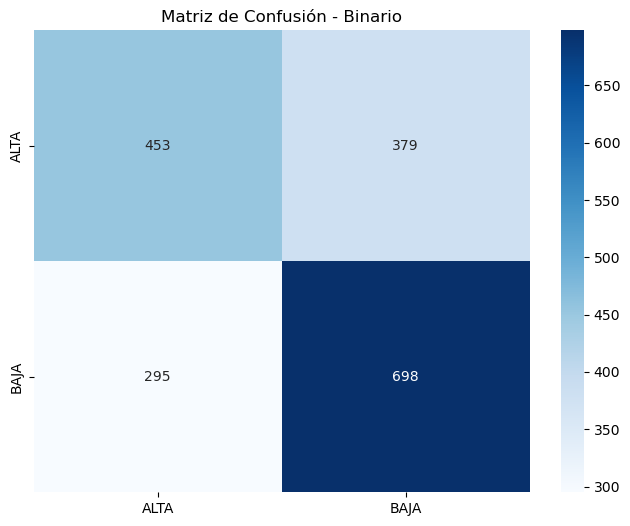


Detalle: TP=698, TN=453, FP=379, FN=295


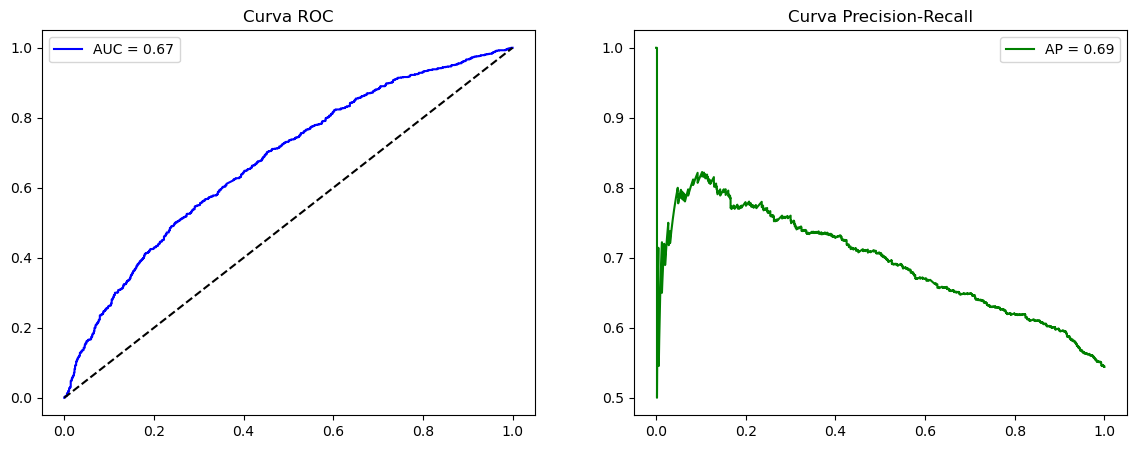

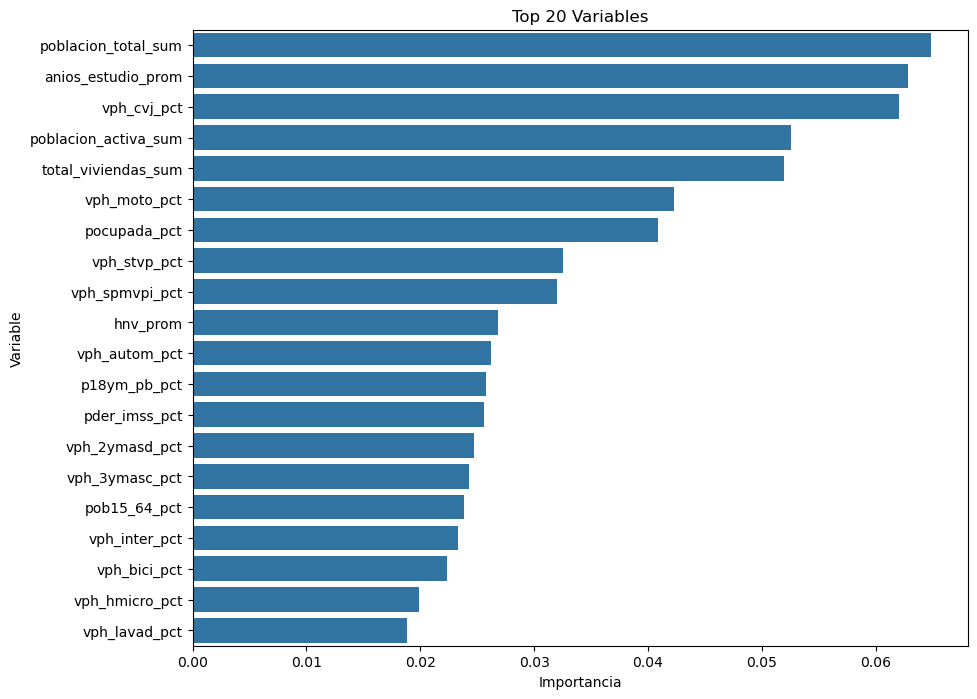

Modelo y Encoder guardados exitosamente.


In [20]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
import multiprocessing
import warnings
from imblearn.combine import SMOTETomek

warnings.filterwarnings('ignore')

# Configuración de núcleos
os.environ['LOKY_MAX_CPU_COUNT'] = '16'

# --- 1. PREPARACIÓN DE DATOS ---
df = df_nse.copy()

# NUEVO: Filtrar para que solo existan 'ALTA' y 'BAJA'
# Si tienes 'MEDIA' y quieres eliminarla, usamos esto:
df = df[df['clasificacion'].isin(['ALTA', 'BAJA'])]
# Nota: Si quisieras agrupar MEDIA con BAJA, usarías: 
# df['clasificacion'] = df['clasificacion'].replace('MEDIA', 'BAJA')

def limpiar_y_convertir(columna):
    columna_str = columna.astype(str)
    columna_limpia = columna_str.str.replace('*', '', regex=False)
    return pd.to_numeric(columna_limpia, errors='coerce')

df.columns = df.columns.str.strip().str.lower().str.replace('\n', ' ')

columnas_grupo = ['nom_ent', 'nom_mun', 'nom_loc', 'cveid_enti', 'nombre']
columnas_grupo = [col for col in columnas_grupo if col in df.columns]

variables_a_sumar = [
    'vph_excsa', 'vph_autom', 'vph_inter', 'pocupada', 'pder_ss', 'p18ym_pb',
    'vph_3ymasc', 'vph_stvp', 'vph_pc', 'vph_cvj', 'vph_2ymasd', 'vph_moto',
    'vph_bici', 'vph_lavad', 'vph_hmicro', 'vph_refri', 'vph_telef', 'vph_spmvpi',
    'vph_tv', 'vph_radio', 'pder_imss', 'vph_1cuart', 'p15sec_co', 'p_0a2',
    'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24', 'pob15_64', 'p_60ymas',
    'p12ym_casa', 'p12ym_solt'
]

vars_present = [var for var in variables_a_sumar if var in df.columns]
for var in vars_present:
    df[var] = limpiar_y_convertir(df[var])
df[vars_present] = df[vars_present].apply(pd.to_numeric, errors='coerce').fillna(0)

df_sums = df.groupby(columnas_grupo)[vars_present].sum().reset_index()

for col in ['tvivparhab', 'pea', 'pobtot','graproes','uni_eco', 'prom_hnv']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('*', '', regex=False), errors='coerce').fillna(0)

df_totales = df.groupby(columnas_grupo).agg({
    'graproes': 'mean', 'tvivparhab': 'sum', 'pea': 'sum',
    'pobtot': 'sum', 'uni_eco': 'sum', 'prom_hnv': 'mean'
}).reset_index().rename(columns={
    'graproes': 'anios_estudio_prom', 'tvivparhab': 'total_viviendas_sum',
    'pea': 'poblacion_activa_sum', 'pobtot': 'poblacion_total_sum',
    'uni_eco': 'total_unidades_economicas_sum', 'prom_hnv': 'hnv_prom'
})

df_totales = pd.merge(df_sums, df_totales, on=columnas_grupo)

for var in variables_a_sumar:
    if var not in df_totales.columns: continue
    if var in ['pocupada', 'pder_imss', 'p18ym_pb']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_activa_sum']
    elif var in ['pder_ss', 'p_0a2', 'p_3a5', 'p_6a11', 'p_12a14', 'p_15a17', 'p_18a24',
                 'pob15_64', 'p_60ymas', 'p12ym_casa', 'p12ym_solt']:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['poblacion_total_sum']
    else:
        df_totales[var + '_pct'] = df_totales[var] * 100 / df_totales['total_viviendas_sum']

# NSE promedio si existe
if 'nse' in df.columns:
    orden_clases = ['E', 'D', 'D+', 'C-', 'C', 'C+', 'AB']
    df['nse'] = pd.Categorical(df['nse'], categories=orden_clases, ordered=True)
    df['nse_num'] = df['nse'].cat.codes
    df_nse_prom = df.groupby(columnas_grupo)['nse_num'].mean().reset_index()
    df_totales = pd.merge(df_totales, df_nse_prom.rename(columns={'nse_num': 'nse_promedio'}), on=columnas_grupo, how='left')

variables_pct = [col for col in df_totales.columns if col.endswith('_pct') or col.endswith('_sum') or col.endswith('_prom')]

# Agrupar clasificación (Target Binario)
df_clasificacion = df.groupby(columnas_grupo)['clasificacion'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
df_model = pd.merge(df_totales, df_clasificacion, on=columnas_grupo, how='left')

# Features adicionales
df_model['ratio_viviendas_persona'] = df_model['total_viviendas_sum'] / (df_model['poblacion_total_sum'] + 1)
df_model['dependencia_economica'] = (df_model['p_0a2_pct'] + df_model['p_3a5_pct'] + df_model['p_60ymas_pct']) / (df_model['pob15_64_pct'] + 1)

X = df_model[variables_pct].copy()
y = df_model['clasificacion'].astype(str)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Codificar etiquetas (BAJA=0, ALTA=1 usualmente por orden alfabético, mejor verificar)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 2. ENTRENAMIENTO ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Cambiado a objective BINARY
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'colsample_bytree': [0.5],
    'learning_rate': [0.05],
    'max_depth': [3],
    'n_estimators': [250],
    'reg_alpha': [5],
    'reg_lambda': [10]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1', # F1 estándar para binario
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

# --- 3. EVALUACIÓN ---
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nREPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Métricas Binarias
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# --- 4. MATRIZ DE CONFUSIÓN ---
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - Binario")
plt.show()

print(f"\nDetalle: TP={TP}, TN={TN}, FP={FP}, FN={FN}")

# --- 5. CURVAS ROC Y PR ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_title('Curva ROC')
ax1.legend()

ax2.plot(recall, precision, color='green', label=f'AP = {average_precision_score(y_test, y_pred_proba):.2f}')
ax2.set_title('Curva Precision-Recall')
ax2.legend()
plt.show()

# --- 6. IMPORTANCIA DE VARIABLES ---
importancias_df = pd.DataFrame({'Variable': X.columns, 'Importancia': best_xgb.feature_importances_}).sort_values(by='Importancia', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importancia', y='Variable', data=importancias_df.head(20))
plt.title("Top 20 Variables")
plt.show()

# Guardar
joblib.dump(best_xgb, "modelo_binario_xgboost.pkl")
joblib.dump(label_encoder, "label_encoder_binario.pkl")
print("Modelo y Encoder guardados exitosamente.")